# Import canonique

In [1]:
# Experiment tracking
import mlflow
from mlflow.data.pandas_dataset import PandasDataset

# DataFrame
import numpy as np
import pandas as pd
from parallel_pandas import ParallelPandas

# Initialize parallel-pandas
ParallelPandas.initialize(n_cpu=14,
                          split_factor=4,
                          disable_pr_bar=False,
                          show_vmem=True)

# Matplot
import matplotlib.pyplot as plt
import seaborn as sns

# # Scikit-learn
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split, learning_curve, cross_val_score,\
                                    GridSearchCV, RandomizedSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression

from sklearn.feature_extraction.text import TfidfVectorizer

# # Keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import Sequential, regularizers
from tensorflow.keras.layers import LSTM, Dense, Embedding, GRU, Bidirectional, Masking, Flatten, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.metrics import Accuracy, Precision, Recall, F1Score
from tensorflow.keras.optimizers import Adam, RMSprop, schedules
from tensorflow.keras.callbacks import ReduceLROnPlateau

# nltk
import nltk
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer, WordNetLemmatizer

# Word2vec
from gensim.models import Word2Vec, KeyedVectors
import gensim.downloader

# # Utility
import re

def compress(df, **kwargs):
    """
    Reduces size of dataframe by downcasting numerical columns
    """
    input_size = df.memory_usage(index=True).sum() / 1024
    print("new dataframe size: ", round(input_size, 2), 'kB')

    in_size = df.memory_usage(index=True).sum()
    for type in ["float", "integer"]:
        l_cols = list(df.select_dtypes(include=type))
        for col in l_cols:
            df[col] = pd.to_numeric(df[col], downcast=type)
    out_size = df.memory_usage(index=True).sum()
    ratio = (1 - round(out_size / in_size, 2)) * 100

    print("optimized size by {} %".format(round(ratio, 2)))
    print("new dataframe size: ", round(out_size / 1024, 2), " kB")

    return df

# Regex de nettoyage
# TEXT_CLEANING_RE = '@\S+|https\S+|http\S+|&.*;|\d+|[^a-zA-Z]'
TEXT_CLEANING_RE = '@\S+|https?:\S+|http?:\S|[^A-Za-z0-9]+'
# Dict des stop words
stop_words = stopwords.words("english")
# Stemmer
stemmer = SnowballStemmer("english")

def cleaning_text_stem(text, exclude_stop_words=True):
 
    text = re.sub(TEXT_CLEANING_RE, ' ', str(text).lower()).strip()
 
    tokens = []
    if exclude_stop_words:
        for token in text.split():
            if token not in stop_words:
                tokens.append(stemmer.stem(token)) 
    else:
        for token in text.split():
            tokens.append(stemmer.stem(token))     
                
    return tokens

def cleaning_text_lemma(text, exclude_stop_words=True, pos='v'):
 
    text = re.sub(TEXT_CLEANING_RE, ' ', str(text).lower()).strip()
 
    if exclude_stop_words:
        tokens = [token for token in text.split() if token not in stop_words]
    else:
        tokens = [token for token in text.split()]
    
    if pos in ['v', 'n']:
            tokens = [WordNetLemmatizer().lemmatize(token, pos = pos)for token in tokens]
    else:
        raise AttributeError(f'Le param `pos` ne peut pas prendre la valeur {pos}, uniquement `v` ou `n`.')
            
                
    return tokens

def import_data()->pd.DataFrame:
    """
    Renvoie le dataset complet (~1.6 m tweets) dédoublonné non traité et sans `user`, `date` et `flag`.
    """
    DATASET_COLUMNS = ["target", "ids", "date", "flag", "user", "text"]
    df = pd.read_csv('./p7_global/data/training.1600000.processed.noemoticon.csv',
                     encoding='latin',
                     header=None,
                     names=DATASET_COLUMNS)
    df.drop(['user', 'date', 'flag'], axis=1, inplace=True)
    df = df[~df.ids.duplicated(keep=False)].reset_index(drop=True)

    return compress(df)

def get_train_and_test_set(df: pd.DataFrame,
                           test_size: float = 0.2,
                           sample: bool = False,
                           sample_size: int = 4000,
                           lemmatizing: bool = True,
                           pos: str = 'v',
                           exclude_stop_words: bool = True) -> np.array:
    """
    Renvoie les jeux de données d'entrainement et de test traités (X_train, X_test, y_train, y_test)
    """
    if sample:
        df = df.sample(sample_size, random_state=32)
        
    if lemmatizing:
        df['text_norm'] = df.text.p_apply(cleaning_text_lemma, pos=pos, exclude_stop_words=exclude_stop_words)

    else:
        df['text_norm'] = df.text.p_apply(cleaning_text_stem, exclude_stop_words=exclude_stop_words)
        

    df_train, df_test = train_test_split(df,
                                     test_size=test_size,
                                     random_state=32)
    X_train = df_train.text_norm
    X_test = df_test.text_norm
    y_train = df_train.target.apply(lambda x: 1 if x == 4 else 0).to_numpy()
    y_test = df_test.target.apply(lambda x: 1 if x == 4 else 0).to_numpy()
    
    return X_train, X_test, y_train, y_test

def get_train_val_and_test_set(df: pd.DataFrame,
                           test_size: float = 0.2,
                           sample: bool = False,
                           sample_size: int = 4000,
                           lemmatizing: bool = True,
                           pos: str = 'v',
                           exclude_stop_words: bool = True) -> np.array:
    """
    Renvoie les jeux de données d'entrainement, de validation et de test traités 
    (X_train, X_val, X_test, y_train, y_val, y_test)
    """
    if sample:
        df = df.sample(sample_size, random_state=32)
        
    if lemmatizing:
        df['text_norm'] = df.text.p_apply(cleaning_text_lemma, pos=pos, exclude_stop_words=exclude_stop_words)

    else:
        df['text_norm'] = df.text.p_apply(cleaning_text_stem, exclude_stop_words=exclude_stop_words)
        

    df_train, df_test = train_test_split(df,
                                     test_size=test_size,
                                     random_state=32)
    
    df_train, df_val = train_test_split(df_train,
                                     test_size=test_size,
                                     random_state=32)
    X_train = df_train.text_norm
    X_val = df_val.text_norm
    X_test = df_test.text_norm
    y_train = df_train.target.apply(lambda x: 1 if x == 4 else 0).to_numpy()
    y_val = df_val.target.apply(lambda x: 1 if x == 4 else 0).to_numpy()
    y_test = df_test.target.apply(lambda x: 1 if x == 4 else 0).to_numpy()
    
    return X_train, X_val, X_test, y_train, y_val, y_test

2023-11-16 07:55:51.290401: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-11-16 07:55:51.291717: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-11-16 07:55:51.312722: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-11-16 07:55:51.312749: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-11-16 07:55:51.312765: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to regi

# Instanciation ML Flow


In [2]:
client = mlflow.MlflowClient(tracking_uri="http://127.0.0.1:8080")

# Import des données

In [3]:
DATASET_COLUMNS = ["target", "ids", "date", "flag", "user", "text"]
df = pd.read_csv('./data/training.1600000.processed.noemoticon.csv', encoding='latin', header=None, names=DATASET_COLUMNS)
df.sample(5, random_state=32)

,target,ids,date,flag,user,text
272912,0,1990296418,Mon Jun 01 04:28:22 PDT 2009,NO_QUERY,stotan88,@omgseriouslywtf no video? try using RapidSha...
1538075,4,2179775832,Mon Jun 15 09:34:02 PDT 2009,NO_QUERY,mmh807,@KimberWitch Sorry to hear that! Feel better! ...
632239,0,2232608234,Thu Jun 18 20:08:38 PDT 2009,NO_QUERY,lola2022,@xoxo_steppie how do I pick a size for any of ...
979871,4,1833972446,Mon May 18 01:08:26 PDT 2009,NO_QUERY,Oli_li,is tired and has sore knees from over excessiv...
1050118,4,1960590356,Fri May 29 08:12:02 PDT 2009,NO_QUERY,chinagurl02,"@gotgame23 lmao...no, but that just made me sm..."


In [4]:
df.dtypes

target     int64
ids        int64
date      object
flag      object
user      object
text      object
dtype: object

In [5]:
compress(df)

new dataframe size:  75000.12 kB
optimized size by 15.0 %
new dataframe size:  64062.62  kB


,target,ids,date,flag,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."
...,...,...,...,...,...,...
1599995,4,2193601966,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,AmandaMarie1028,Just woke up. Having no school is the best fee...
1599996,4,2193601969,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,TheWDBoards,TheWDB.com - Very cool to hear old Walt interv...
1599997,4,2193601991,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,bpbabe,Are you ready for your MoJo Makeover? Ask me f...
1599998,4,2193602064,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,tinydiamondz,Happy 38th Birthday to my boo of alll time!!! ...


In [6]:
df.dtypes

target      int8
ids        int64
date      object
flag      object
user      object
text      object
dtype: object

# EDA

## Variable cible (`target`)

D'après le dictionnaire de données la cible contient trois catégories:
- 0: Négatif
- 2: Neutre
- 4: Positif

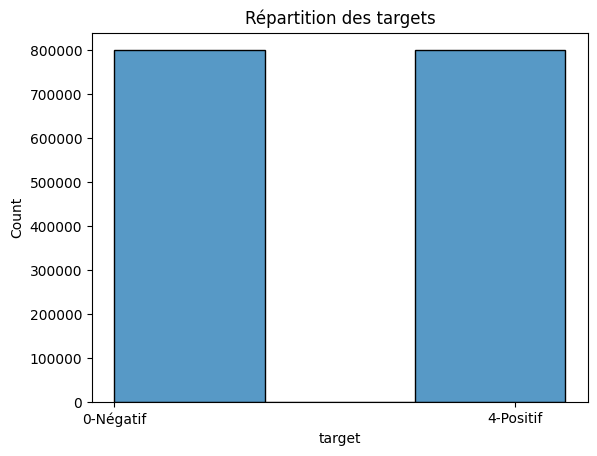

In [7]:
sns.histplot(data=df, x='target',binwidth = 1.5, )
plt.xticks([0,4])
plt.title('Répartition des targets')
plt.xticks(ticks=[0,4], labels=["0-Négatif", "4-Positif"]);

## `flag`

La colonne flag contient une seule valeur, elle peut donc être supprimée.

In [8]:
df.flag.unique()

array(['NO_QUERY'], dtype=object)

In [9]:
df.drop('flag', axis=1, inplace=True)

## `ids`

La colonne `ids` contient l'identifiant du message.

On note que l'on a moins d'identifiants unique que de messages, on peut donc penser que l'on a des doublons.

In [10]:
df.ids.nunique()

1598315

In [11]:
df[df.ids.duplicated(keep=False)].sort_values(by='ids')

,target,ids,date,user,text
213,0,1467863684,Mon Apr 06 22:33:35 PDT 2009,DjGundam,Awwh babs... you look so sad underneith that s...
800261,4,1467863684,Mon Apr 06 22:33:35 PDT 2009,DjGundam,Awwh babs... you look so sad underneith that s...
275,0,1467880442,Mon Apr 06 22:38:04 PDT 2009,iCalvin,Haven't tweeted nearly all day Posted my webs...
800300,4,1467880442,Mon Apr 06 22:38:04 PDT 2009,iCalvin,Haven't tweeted nearly all day Posted my webs...
989,0,1468053611,Mon Apr 06 23:28:09 PDT 2009,mariejamora,@hellobebe I also send some updates in plurk b...
...,...,...,...,...,...
524290,0,2193428118,Tue Jun 16 08:26:44 PDT 2009,bubbles00,"finally finished typing!!!! Woohoooo , still ..."
1599440,4,2193451289,Tue Jun 16 08:28:37 PDT 2009,faiznurdavid,"@fanafatin see, @misschimichanga tweet u to jo..."
524345,0,2193451289,Tue Jun 16 08:28:37 PDT 2009,faiznurdavid,"@fanafatin see, @misschimichanga tweet u to jo..."
524688,0,2193576442,Tue Jun 16 08:38:45 PDT 2009,emma_b_xox,Had an injection today. Not fun the rrst of t...


On constate ici que les doublons correspondent à des messages classés à la fois en négatif et en positif.

Pour éviter d'envoyer des données potentiellement mal classifiées au modèle on supprimera totalement ces messages et pas uniquement un seul des deux enregistrements (cela est aussi permis par leur faible nombre).

In [12]:
shape_base = df.shape[0]
df = df[~df.ids.duplicated(keep=False)].reset_index(drop=True)
print(f"Nouveau nombre de message disponibles :{df.shape[0]} ({shape_base - df.shape[0]} de moins)")
del shape_base

Nouveau nombre de message disponibles :1596630 (3370 de moins)


## `user` et `date`

Les colonnes user présentent peu d'intérêt pour de la classification de sentiments, on va donc les supprimer.

In [13]:
df.drop(['user', 'date'], axis=1, inplace=True)

# Preprocessing `text`

On va nettoyer les commentaires en enlevant les noms d'utilisateurs, les url et les balises html.<br><br>
On aura ensuite le choix d'enlever ou non les stop words (petits mots de liaisons type pronom ou conjonction de coordination).<br>
On laisse ce choix afin de tester des modalités de textes n'étant pas nettoyés de mots $"not"$ qui peuvent avoir un poids important pour de la détection de sentiment?

Enfin on aura deux solutions de normalisation des mots qui ont toutes les deux pour but de regrouper les mots similaires (`['played', 'playing', 'plays'] == 'play'`) vers un élément commun:
- le stemming qui ramène les mots à leur radical (`['chocolatey', 'chocolate', 'chocolates'] == 'choco'`)
- le lemmatizing qui renvoie un mot racine commun à différents termes selon leur contexte et sur la base d'un dictionnaire(`['am', 'are', 'is', 'being'] == 'be'`)

<details>
    <summary>Détail de la regex :</summary> 
    <ul>
        <li><code>@\S+</code> enlève les usernames dans le texte</li>
        <li><code>https\S+|http\S+</code> enlève les url</li>
        <li><code>[^A-Za-z0-9]+</code> enlève tous les caractères spéciaux</li>
    </ul>
</details>


In [14]:
# Regex de nettoyage
# TEXT_CLEANING_RE = '@\S+|https\S+|http\S+|&.*;|\d+|[^a-zA-Z]'
TEXT_CLEANING_RE = '@\S+|https?:\S+|http?:\S|[^A-Za-z0-9]+'
# Dict des stop words
stop_words = stopwords.words("english")
# Stemmer
stemmer = SnowballStemmer("english")

def cleaning_text_stem(text, exclude_stop_words=True):
 
    text = re.sub(TEXT_CLEANING_RE, ' ', str(text).lower()).strip()
 
    tokens = []
    if exclude_stop_words:
        for token in text.split():
            if token not in stop_words:
                tokens.append(stemmer.stem(token)) 
    else:
        for token in text.split():
            tokens.append(stemmer.stem(token))     
                
    return tokens


def cleaning_text_lemma(text, exclude_stop_words=True, pos='v'):
 
    text = re.sub(TEXT_CLEANING_RE, ' ', str(text).lower()).strip()
 
    if exclude_stop_words:
        tokens = [token for token in text.split() if token not in stop_words]
    else:
        tokens = [token for token in text.split()]
    
    if pos in ['v', 'n']:
            tokens = [WordNetLemmatizer().lemmatize(token, pos = pos)for token in tokens]
    else:
        raise AttributeError(f'Le param `pos` ne peut pas prendre la valeur {pos}, uniquement `v` ou `n`.')
            
                
    return tokens


In [15]:
print(df.iloc[237821].text)
print('lemmatizing (pos==nom) :',cleaning_text_lemma(df.iloc[237821].text, pos='n'))
print('lemmatizing (pos==verb) :',cleaning_text_lemma(df.iloc[237821].text, pos='v'))
print('stemming :',cleaning_text_stem(df.iloc[237821].text))

@metal51 Oh, sorry ong Vu,nhin vo Twitter toan chu la chu, hong de y ong nhan.Sorry:&gt;.Hoc cung binh thuong thoi ah,hong muon noi la ngan 
lemmatizing (pos==nom) : ['oh', 'sorry', 'ong', 'vu', 'nhin', 'vo', 'twitter', 'toan', 'chu', 'la', 'chu', 'hong', 'de', 'ong', 'nhan', 'sorry', 'gt', 'hoc', 'cung', 'binh', 'thuong', 'thoi', 'ah', 'hong', 'muon', 'noi', 'la', 'ngan']
lemmatizing (pos==verb) : ['oh', 'sorry', 'ong', 'vu', 'nhin', 'vo', 'twitter', 'toan', 'chu', 'la', 'chu', 'hong', 'de', 'ong', 'nhan', 'sorry', 'gt', 'hoc', 'cung', 'binh', 'thuong', 'thoi', 'ah', 'hong', 'muon', 'noi', 'la', 'ngan']
stemming : ['oh', 'sorri', 'ong', 'vu', 'nhin', 'vo', 'twitter', 'toan', 'chu', 'la', 'chu', 'hong', 'de', 'ong', 'nhan', 'sorri', 'gt', 'hoc', 'cung', 'binh', 'thuong', 'thoi', 'ah', 'hong', 'muon', 'noi', 'la', 'ngan']


In [16]:
print(df.iloc[379332].text)
print('lemmatizing (pos==nom) :',cleaning_text_lemma(df.iloc[379332].text, pos='n'))
print('lemmatizing (pos==verb) :',cleaning_text_lemma(df.iloc[379332].text, pos='v'))
print('stemming :',cleaning_text_stem(df.iloc[379332].text))

@neospace à¹à¸£à¸·à¹à¸­à¸à¸à¸±à¹à¸à¸à¸£à¸£à¸à¹à¸à¸£à¸² à¹à¸«à¹à¸à¸à¹à¸§à¸¢à¸à¸µà¹à¹à¸¡à¹à¸à¹à¸­à¸à¹à¸à¸à¸±à¹à¸à¹à¹à¸¥à¹à¸à¸?à¸²à¸£à¹à¸¡à¸·à¸­à¸ &quot;à¸à¹à¸²à¸à¸à¸à¸&quot; à¸?à¸±à¸à¸­à¸µà¸? à¹?à¸à¹à¸à¸µà¹à¸¡à¸²à¸à¸µà¹à¹à¸à¹à¸«à¹à¸à¹?à¸¥à¹à¸§ à¸à¸±à¸à¸à¸²à¸¡à¸²à¸? à¸à¸£à¸£à¸à¹à¸à¸µà¸¢à¸§ Green Party 
lemmatizing (pos==nom) : ['quot', 'quot', 'green', 'party']
lemmatizing (pos==verb) : ['quot', 'quot', 'green', 'party']
stemming : ['quot', 'quot', 'green', 'parti']


In [17]:
print(df.iloc[225535].text)
print('lemmatizing (pos==nom) :',cleaning_text_lemma(df.iloc[225535].text, pos='n'))
print('lemmatizing (pos==verb) :',cleaning_text_lemma(df.iloc[225535].text, pos='v'))
print('stemming :',cleaning_text_stem(df.iloc[225535].text))

@LadyLucius LOL- I do not have AT&amp;T so NO I-Phone for me!    Believe me I am a total Mac/Apple Whore! I was in the Apple Store today!
lemmatizing (pos==nom) : ['lol', 'amp', 'phone', 'believe', 'total', 'mac', 'apple', 'whore', 'apple', 'store', 'today']
lemmatizing (pos==verb) : ['lol', 'amp', 'phone', 'believe', 'total', 'mac', 'apple', 'whore', 'apple', 'store', 'today']
stemming : ['lol', 'amp', 'phone', 'believ', 'total', 'mac', 'appl', 'whore', 'appl', 'store', 'today']


In [18]:
print(df.iloc[650400].text)
print('lemmatizing (pos==nom) :',cleaning_text_lemma(df.iloc[650400].text, pos='n'))
print('lemmatizing (pos==verb) :',cleaning_text_lemma(df.iloc[650400].text, pos='v'))
print('stemming :',cleaning_text_stem(df.iloc[650400].text))

@cupcakemafia wull I hate to hear 'bout an awesome chickie playing hood ornament  You doing ok?
lemmatizing (pos==nom) : ['wull', 'hate', 'hear', 'bout', 'awesome', 'chickie', 'playing', 'hood', 'ornament', 'ok']
lemmatizing (pos==verb) : ['wull', 'hate', 'hear', 'bout', 'awesome', 'chickie', 'play', 'hood', 'ornament', 'ok']
stemming : ['wull', 'hate', 'hear', 'bout', 'awesom', 'chicki', 'play', 'hood', 'ornament', 'ok']


In [19]:
print(df.iloc[621692].text)
print('lemmatizing (pos==nom) :',cleaning_text_lemma(df.iloc[621692].text, pos='n'))
print('lemmatizing (pos==verb) :',cleaning_text_lemma(df.iloc[621692].text, pos='v'))
print('stemming :',cleaning_text_stem(df.iloc[621692].text))

My Bestest Friend= Xeniesha :]  Nicole left!! She official left to Chicago!! So Sad!! 
lemmatizing (pos==nom) : ['bestest', 'friend', 'xeniesha', 'nicole', 'left', 'official', 'left', 'chicago', 'sad']
lemmatizing (pos==verb) : ['bestest', 'friend', 'xeniesha', 'nicole', 'leave', 'official', 'leave', 'chicago', 'sad']
stemming : ['bestest', 'friend', 'xeniesha', 'nicol', 'left', 'offici', 'left', 'chicago', 'sad']


In [20]:
print(df.iloc[1125888].text)
print('lemmatizing (pos==nom) :',cleaning_text_lemma(df.iloc[1125888].text, pos='n'))
print('lemmatizing (pos==verb) :',cleaning_text_lemma(df.iloc[1125888].text, pos='v'))
print('stemming :',cleaning_text_stem(df.iloc[1125888].text))

Very thankful for Nikon's CLS system today.  1/1250s with full flash capabilities is simply awesome 
lemmatizing (pos==nom) : ['thankful', 'nikon', 'cl', 'system', 'today', '1', '1250s', 'full', 'flash', 'capability', 'simply', 'awesome']
lemmatizing (pos==verb) : ['thankful', 'nikon', 'cls', 'system', 'today', '1', '1250s', 'full', 'flash', 'capabilities', 'simply', 'awesome']
stemming : ['thank', 'nikon', 'cls', 'system', 'today', '1', '1250s', 'full', 'flash', 'capabl', 'simpli', 'awesom']


In [21]:
print(df.iloc[1313450].text)
print('lemmatizing (pos==nom) :',cleaning_text_lemma(df.iloc[1313450].text, pos='n'))
print('lemmatizing (pos==verb) :',cleaning_text_lemma(df.iloc[1313450].text, pos='v'))
print('stemming :',cleaning_text_stem(df.iloc[1313450].text))

Meet Cactuar - my mini cactus friend.  http://twitgoo.com/muj7
lemmatizing (pos==nom) : ['meet', 'cactuar', 'mini', 'cactus', 'friend']
lemmatizing (pos==verb) : ['meet', 'cactuar', 'mini', 'cactus', 'friend']
stemming : ['meet', 'cactuar', 'mini', 'cactus', 'friend']


In [22]:
print(df.iloc[186683].text)
print('lemmatizing (pos==nom) :',cleaning_text_lemma(df.iloc[186683].text, pos='n'))
print('lemmatizing (pos==verb) :',cleaning_text_lemma(df.iloc[186683].text, pos='v'))
print('stemming :',cleaning_text_stem(df.iloc[186683].text))

A book that hadn't been opened for 100 years? Totally would gotten weeded from our branch. 
lemmatizing (pos==nom) : ['book', 'opened', '100', 'year', 'totally', 'would', 'gotten', 'weeded', 'branch']
lemmatizing (pos==verb) : ['book', 'open', '100', 'years', 'totally', 'would', 'get', 'weed', 'branch']
stemming : ['book', 'open', '100', 'year', 'total', 'would', 'gotten', 'weed', 'branch']


In [23]:
df['text_stem'] = df.text.p_apply(cleaning_text_stem)
df['text_lem_wt_stop_words'] = df.text.p_apply(cleaning_text_lemma, exclude_stop_words=False)
df['text_lem'] = df.text.p_apply(cleaning_text_lemma)

CLEANING_TEXT_STEM DONE:   0%|          | 0/1596630 [00:00<?, ?it/s]

VMEM USAGE: 41.0%|####1     |  15.2G

CLEANING_TEXT_LEMMA DONE:   0%|          | 0/1596630 [00:00<?, ?it/s]

VMEM USAGE: 46.4%|####6     |  15.2G

CLEANING_TEXT_LEMMA DONE:   0%|          | 0/1596630 [00:00<?, ?it/s]

VMEM USAGE: 55.5%|#####5    |  15.2G

## Taille des documents après prétraitement

Les tweets étant traités on peut s'intéresser à la longueur de textes disponibles, information qui sera utile pour le plongement de mots réalisé ensuite.

In [24]:
df['long'] = df.text.str.len()
df['long_text_lem'] = df.text_lem.apply(len)

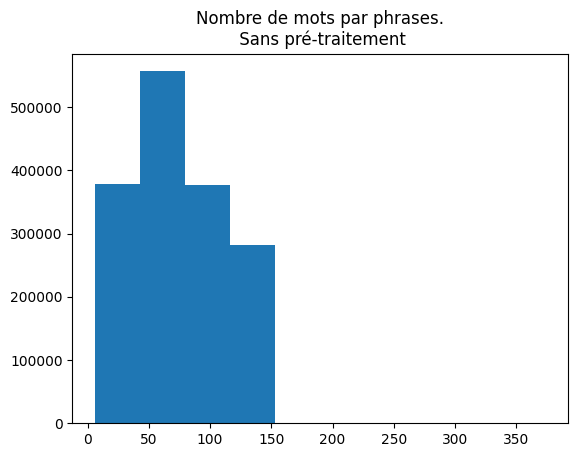

In [25]:
plt.hist(df.long)
plt.title("Nombre de mots par phrases.\n Sans pré-traitement");

In [26]:
df.long.describe().apply('{:,.2f}'.format)

count    1,596,630.00
mean            74.04
std             36.44
min              6.00
25%             44.00
50%             69.00
75%            104.00
max            374.00
Name: long, dtype: object

In [27]:
df[df.long >300]

,target,ids,text,text_stem,text_lem_wt_stop_words,text_lem,long,long_text_lem
379332,0,2052585042,@neospace à¹à¸£à¸·à¹à¸­à¸à¸à¸±à¹à¸à¸à¸£...,"[quot, quot, green, parti]","[quot, quot, green, party]","[quot, quot, green, party]",359,4
649260,0,2237729497,human shield à®à®©à¯?à®± à®à¯à®±à¯?à®¤à¯à®...,"[human, shield]","[human, shield]","[human, shield]",348,2
1228956,4,1991794613,@doax ì´ì°¨í¼ bandwidthë ë¶ì° íì?¼ ì...,"[bandwidth, ssd]","[bandwidth, ssd]","[bandwidth, ssd]",312,2
1261447,4,1999178267,"@msathia à®®à¯?à®¹à¯à®®à¯?, à®ªà®¯à®®à¯?à®±à¯...",[2],[2],[2],323,1
1292538,4,2003659618,@catfish_ohm à¹à¸à¹à¸²à¹à¸«à¹à¸?à¸²à¸£à¹...,[],[],[],374,0
1316450,4,2014458885,@laches [æçèª å¯¦å ­ååæ¶] æè¿è·ä...,[lach],[laches],[laches],314,1
1355368,4,2048179655,@thanr à¹à¸à¸µà¹à¸¢à¸§à¹à¸­à¸²à¸£à¸²à¸à¸²...,[],[],[],326,0
1394450,4,2053957784,ê·¼ë?° ë¡ë°¥ì?´ìì¼ë ì± ìì§ê³ ë ë¤...,[hitdg],[hitdg],[hitdg],313,1
1447883,4,2062991891,@KaewGB à¸­à¹à¸­ à¹à¸à¸¢à¸à¸²à¸¡à¹à¹à¸...,"[55, resourc, ku, vpn, v]","[55, resource, ku, vpn, v]","[55, resource, ku, vpn, v]",328,5
1481753,4,2067748792,@iannnnn à¹à¸à¸µà¹à¸¢à¸§à¸­à¸µà¸?à¸à¸±à¸?à...,[graphic],[graphic],[graphic],369,1


On voit que les tweets les plus longs contiennent beaucoup de caractères non-ascii et donc non exploitable.

---

On constate en revanche que les tweets les plus longs après retraitement sont soit dans une langue autre que l'anglais soit composés de mots incluants des chiffres (`look`-->`l00k`)

In [28]:
df.long_text_lem.describe().apply('{:,.2f}'.format)

count    1,596,630.00
mean             7.20
std              4.05
min              0.00
25%              4.00
50%              7.00
75%             10.00
max             50.00
Name: long_text_lem, dtype: object

In [29]:
df[df.long_text_lem >df.long_text_lem.quantile(.9999)].sort_values(by='long_text_lem')

,target,ids,text,text_stem,text_lem_wt_stop_words,text_lem,long,long_text_lem
739295,0,2266135402,@Ky_hamho MÃ¬nh tháº¥y trÃªn H2T cÃ³ nÃ³i nhÃ¬...,"[nh, th, tr, n, h2t, c, n, nh, u, v, twitter, ...","[m, nh, th, y, tr, n, h2t, c, n, i, nh, u, v, ...","[nh, th, tr, n, h2t, c, n, nh, u, v, twitter, ...",143,27
1021202,4,1882993884,cnt wait 2 go in town 2moz gt to gt rid of mi ...,"[cnt, wait, 2, go, town, 2moz, gt, gt, rid, mi...","[cnt, wait, 2, go, in, town, 2moz, gt, to, gt,...","[cnt, wait, 2, go, town, 2moz, gt, gt, rid, mi...",124,27
367350,0,2049547916,"@TWANI_E won 1 &amp; lost 2, bt we ate @ 7 dis...","[1, amp, lost, 2, bt, ate, 7, dis, morn, amp, ...","[win, 1, amp, lose, 2, bt, we, eat, 7, dis, mo...","[1, amp, lose, 2, bt, eat, 7, dis, morn, amp, ...",149,27
1320175,4,2014853411,@karennz My pic is weird!!! lol I look like Co...,"[pic, weird, lol, look, like, compo, lipstick,...","[my, pic, be, weird, lol, i, look, like, compo...","[pic, weird, lol, look, like, compo, lipstick,...",136,27
505147,0,2188733366,No puedo dormir esta es una de esas noches fe...,"[puedo, dormir, esta, es, una, de, esa, noch, ...","[no, puedo, dormir, esta, es, una, de, esas, n...","[puedo, dormir, esta, es, una, de, esas, noche...",138,27
...,...,...,...,...,...,...,...,...
564778,0,2206850784,ChÆ°a ká»p thá» máº¡nh ÄÃ£ láº¡i nÃ­n thá»...,"[ch, k, p, th, nh, l, n, n, th, lao, v, cu, c,...","[ch, a, k, p, th, m, nh, l, i, n, n, th, lao, ...","[ch, k, p, th, nh, l, n, n, th, lao, v, cu, c,...",188,37
1521771,4,2176797642,NghÄ© ÄÆ¡n giáº£n nhÆ° tháº¿ nÃ y.ThÃ´i khÃ´n...,"[ngh, n, gi, n, nh, th, n, th, kh, ng, c, n, c...","[ngh, n, gi, n, nh, th, n, y, th, i, kh, ng, c...","[ngh, n, gi, n, nh, th, n, th, kh, ng, c, n, c...",181,37
1170693,4,1980719552,"I know pi to 12 digits. &quot;c&quot;,&quot;h...","[know, pi, 12, digit, quot, c, quot, quot, h, ...","[i, know, pi, to, 12, digits, quot, c, quot, q...","[know, pi, 12, digits, quot, c, quot, quot, h,...",220,38
1167097,4,1980274822,"out in tha summer sun, having fun... nej, plug...","[tha, summer, sun, fun, nej, pluggar, men, nd,...","[out, in, tha, summer, sun, have, fun, nej, pl...","[tha, summer, sun, fun, nej, pluggar, men, nd,...",171,40


In [30]:
df['long_text_lem_wt_stop_words'] = df.text_lem_wt_stop_words.apply(len)
df['long_text_stem'] = df.text_stem.apply(len)

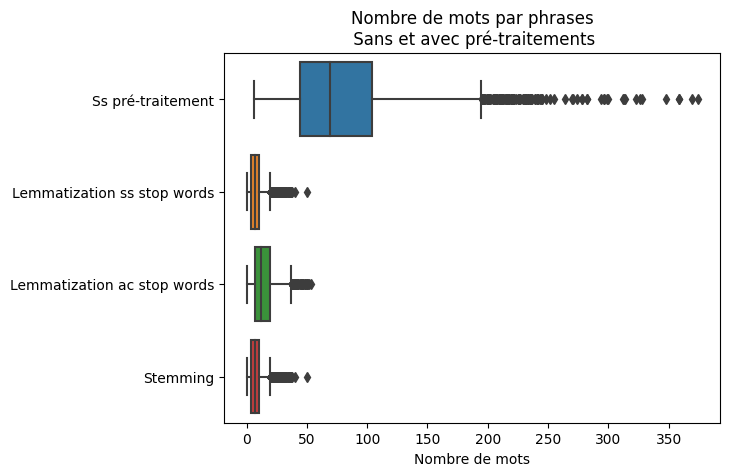

In [31]:
sns.boxplot(data=df.iloc[:,-4:], orient='h')
plt.title("Nombre de mots par phrases\n Sans et avec pré-traitements")
plt.xlabel('Nombre de mots')
plt.yticks(ticks=range(4),labels=['Ss pré-traitement', 'Lemmatization ss stop words', 'Lemmatization ac stop words', 'Stemming']);

In [32]:
print("Nombre de textes vides après traitement:" ,df[df.long_text_lem == 0].shape[0])

Nombre de textes vides après traitement: 7668


In [33]:
cond1 = df.long_text_lem == 0
cond2 = df.long_text_lem > df.long_text_lem.quantile(.9999)
df[~(cond2 | cond1)].shape[0]

1588818

Enfin on peut voir que le traitements de tweets peut créer des listes vides qui doivent donc être supprimés car inexploitables.

On se retrouvera finalement avec un dataset complet de $1588818$ contre $1600000$ à l'import ($11182$ tweets supprimés).

In [34]:
df = df[~(cond2 | cond1)]
del cond2, cond1

In [35]:
path = './data/cleaned_data.csv'
# df.to_csv(path, index=False)

In [36]:
# df = pd.read_csv(path)
# df.head()

# Modèle baseline

On crée un modèle de base pour avoir une référence.

Ici notre modèle de base renvoie la valeur la plus fréquente dans le jeu d'entrainement.

In [37]:
df_train, df_test = train_test_split(df.sample(4_000, random_state=32), test_size=.2, random_state=42)
print("TRAIN size:", len(df_train))
print("TEST size:", len(df_test))

del df

TRAIN size: 3200
TEST size: 800


In [38]:
# Création de la target
y_train = df_train.target.apply(lambda x: 1 if x==4 else 0).to_numpy()
y_test = df_test.target.apply(lambda x: 1 if x==4 else 0).to_numpy()

In [39]:

unique, counts = np.unique(y_train, return_counts=True)
counts = dict(zip(unique, counts))
print("Nombre de tweet dans le jeu d'entrainements", counts)

y_pred = 0 if counts[0] > counts[1] else 1
del unique, counts
print('Accuracy baseline: ', accuracy_score(y_test, [y_pred]*len(y_test)))

Nombre de tweet dans le jeu d'entrainements {0: 1570, 1: 1630}
Accuracy baseline:  0.48


# Modèle simple : Régression logistique

In [41]:
# Déclaration à faire à la première utilisation uniquement.

# experiment_description = (
#     "P7 OC : Détection de bad buzz dans des tweets"
#     "Cette expérimentation se fait sur les données prepocessées vectorisées via Tf-idf et passées à une régression logistique."
# )

# experiment_tags = {
#     "project_name": "P7_Detecter_bad_buz",
#     "preprocessing_stop_words_excluded": 'True',
#     "preprocessing_normalisation": "lemmatization",
#     "preprocessing_lemmatization_pos": "verb",
#     "vectorization" : 'Tf-idf',
#     "word_embedding" : 'None',
#     "model_classif": "regression_logistique",
#     "mlflow.note.content": experiment_description,
# }

# modele_simple_experiment = client.create_experiment(name="modele_simple", tags=experiment_tags)


In [42]:
# tf_idf_vectorizer = TfidfVectorizer()

# weighted_words = pd.DataFrame(tf_idf_vectorizer.fit_transform(df_train.text_lem.apply(' '.join)),
#                     index=df_train.text)
# print('Shape du résultat obtenu:',weighted_words.shape)
# print(weighted_words.columns)


In [4]:
df = import_data()
X_train, X_test, y_train, y_test = get_train_and_test_set(df, sample=True, sample_size=4_000)

new dataframe size:  37421.14 kB
optimized size by 29.0 %
new dataframe size:  26506.68  kB


CLEANING_TEXT_LEMMA DONE:   0%|          | 0/4000 [00:00<?, ?it/s]

VMEM USAGE: 35.3%|###5      |  15.2G

In [7]:
tf_idf_vectorizer = TfidfVectorizer()
tf_idf_vectorizer.fit_transform(X_train.apply(' '.join))

<3200x5929 sparse matrix of type '<class 'numpy.float64'>'
	with 21695 stored elements in Compressed Sparse Row format>

In [8]:
del tf_idf_vectorizer
pipe_LR = make_pipeline(TfidfVectorizer(),LogisticRegression(max_iter=10000))
pipe_LR

Pipeline(steps=[('tfidfvectorizer', TfidfVectorizer()),
                ('logisticregression', LogisticRegression(max_iter=10000))])

In [11]:

grid_search_classic_solver = GridSearchCV(
    pipe_LR,
    param_grid={
        
        'logisticregression__C': [i/100 for i in range(0, 21, 2)],
        'logisticregression__tol': [i/100 for i in range(0, 21, 2)],
        'logisticregression__penalty': ['l2'],
        'logisticregression__solver': ['lbfgs', 'newton-cholesky']
    },
    cv=3,
    n_jobs=-2,
    verbose=1,
    scoring="roc_auc")
grid_search_classic_solver.fit(X_train.apply(' '.join), y_train)
grid_search_classic_solver.best_params_


Fitting 3 folds for each of 242 candidates, totalling 726 fits


/home/pjcggf/.pyenv/versions/3.10.6/envs/OC/lib/python3.10/site-packages/sklearn/linear_model/_glm/_newton_solver.py:287: ConvergenceWarning: Line search of Newton solver NewtonCholeskySolver at iteration #5 did no converge after 21 line search refinement iterations. It will now resort to lbfgs instead.
  warnings.warn(
/home/pjcggf/.pyenv/versions/3.10.6/envs/OC/lib/python3.10/site-packages/sklearn/linear_model/_glm/_newton_solver.py:287: ConvergenceWarning: Line search of Newton solver NewtonCholeskySolver at iteration #6 did no converge after 21 line search refinement iterations. It will now resort to lbfgs instead.
  warnings.warn(
/home/pjcggf/.pyenv/versions/3.10.6/envs/OC/lib/python3.10/site-packages/sklearn/linear_model/_glm/_newton_solver.py:287: ConvergenceWarning: Line search of Newton solver NewtonCholeskySolver at iteration #5 did no converge after 21 line search refinement iterations. It will now resort to lbfgs instead.
  warnings.warn(
/home/pjcggf/.pyenv/versions/3.10.

/home/pjcggf/.pyenv/versions/3.10.6/envs/OC/lib/python3.10/site-packages/sklearn/linear_model/_glm/_newton_solver.py:287: ConvergenceWarning: Line search of Newton solver NewtonCholeskySolver at iteration #6 did no converge after 21 line search refinement iterations. It will now resort to lbfgs instead.
  warnings.warn(
/home/pjcggf/.pyenv/versions/3.10.6/envs/OC/lib/python3.10/site-packages/sklearn/linear_model/_glm/_newton_solver.py:287: ConvergenceWarning: Line search of Newton solver NewtonCholeskySolver at iteration #6 did no converge after 21 line search refinement iterations. It will now resort to lbfgs instead.
  warnings.warn(
/home/pjcggf/.pyenv/versions/3.10.6/envs/OC/lib/python3.10/site-packages/sklearn/linear_model/_glm/_newton_solver.py:287: ConvergenceWarning: Line search of Newton solver NewtonCholeskySolver at iteration #6 did no converge after 21 line search refinement iterations. It will now resort to lbfgs instead.
  warnings.warn(
/home/pjcggf/.pyenv/versions/3.10.

{'logisticregression__C': 0.2,
 'logisticregression__penalty': 'l2',
 'logisticregression__solver': 'newton-cholesky',
 'logisticregression__tol': 0.06}

In [12]:
pipe_LR = grid_search_classic_solver.best_estimator_

In [13]:
y_pred = pipe_LR.predict(X_test.apply(' '.join))

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)

print('Accuracy =', round(accuracy, 2)) 
print('Precision =', round(precision, 2))
print('Recall =', round(recall, 2))


Accuracy = 0.68
Precision = 0.65
Recall = 0.77


In [18]:
mlflow.set_tracking_uri("http://127.0.0.1:8080")
modele_simple_experiment = mlflow.set_experiment("modele_simple")


# Nom de l'itération en cours et chemin de stockage du modèle
run_name = "modele_simple_RL_test"
artifact_path = "RL_simple"

metrics = {"accuracy": accuracy, "precision": precision, "recall": recall}

# Information sur le dataset utilisé
dataset: PandasDataset = mlflow.data.from_pandas(df=pd.DataFrame(X_train))

with mlflow.start_run(run_name=run_name) as run:
    # paramètres du modèle
    mlflow.log_params(grid_search_classic_solver.best_params_)

    # Métriques
    mlflow.log_metrics(metrics)


    # Log d'une instance du modèle fitée
    mlflow.sklearn.log_model(sk_model=pipe_LR, input_example=pd.DataFrame(X_test), artifact_path=artifact_path)
    
    # Log des paramètres du dataset.
    mlflow.log_input(dataset, context="training")



/home/pjcggf/.pyenv/versions/3.10.6/envs/OC/lib/python3.10/site-packages/mlflow/models/signature.py:362: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  output_schema = _infer_schema(prediction)
/home/pjcggf/.pyenv/versions/3.10.6/envs/OC/lib/python3.10/site-packages/_distutils_hack/__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is

# Modèle RNN

In [3]:
def plot_loss_accuracy(history):
    fig = plt.figure(figsize=(10,6))
    try:
        fig.suptitle(f'Résultats des métriques du modèle {history.model.name}')
    except:
            fig.suptitle('Résultats des métriques du modèle.')
    
    ax1 = fig.add_subplot(2,2,1)
    ax1.plot(history.history['loss'])
    ax1.plot(history.history['val_loss'])
    ax1.set_title('Model loss')
    ax1.set_ylabel('Loss')
    ax1.set_xlabel('Epoch')
    ax1.legend(['Train', 'Test'], loc='best')

    ax2 = fig.add_subplot(2,2,2)
    ax2.plot(history.history['accuracy'])
    ax2.plot(history.history['val_accuracy'])
    ax2.set_title('Model Accuracy')
    ax2.set_ylabel('Accuracy')
    ax2.set_xlabel('Epoch')
    ax2.legend(['Train', 'Test'], loc='best')


    ax3 = fig.add_subplot(2,2,3)
    ax3.plot(history.history[list(history.history.keys())[2]])
    ax3.plot(history.history[list(history.history.keys())[6]])
    ax3.set_title('Model Precision')
    ax3.set_ylabel('Precision')
    ax3.set_xlabel('Epoch')
    ax3.legend(['Train', 'Test'], loc='best')

    ax4 = fig.add_subplot(2,2,4)
    ax4.plot(history.history[list(history.history.keys())[3]])
    ax4.plot(history.history[list(history.history.keys())[-1]])
    ax4.set_title('Model Recall')
    ax4.set_ylabel('Recall')
    ax4.set_xlabel('Epoch')
    ax4.legend(['Train', 'Test'], loc='best')
    fig.tight_layout(pad=3, h_pad=2)

    plt.show()


## Modèle simple Embedding basique + RNN 

In [32]:
# Déclaration à faire à la première utilisation uniquement.

# experiment_description = (
#     "P7 OC : Détection de bad buzz dans des tweets"
#     "Cette expérimentation se fait sur les données prepocessées normalisées passées à un RNN custom."
# )

# experiment_tags = {
#     "project_name": "P7_Detecter_bad_buz",
#     "model_classif": "rnn_custom",
#     "mlflow.note.content": experiment_description,
# }

# modele_simple_experiment = client.create_experiment(name="rnn_custom", tags=experiment_tags)


In [7]:
df = import_data()
X_train, X_val, X_test, y_train, y_val, y_test = get_train_val_and_test_set(
    df, sample=True, sample_size=50_000)

new dataframe size:  37421.14 kB
optimized size by 29.0 %
new dataframe size:  26506.68  kB


CLEANING_TEXT_LEMMA DONE:   0%|          | 0/50000 [00:00<?, ?it/s]

VMEM USAGE: 72.0%|#######2  |  15.2G

In [8]:
# This initializes a Keras utilities that does all the tokenization for you
tokenizer = Tokenizer()

# The tokenization learns a dictionary that maps a token (integer) to each word
# It can be done only on the train set - we are not supposed to know the test set!
# This tokenization also lowercases your words, apply some filters, and so on - you can check the doc if you want
tokenizer.fit_on_texts(X_train)
    
# We apply the tokenization to the train and test set
X_train_token = tokenizer.texts_to_sequences(X_train)
X_val_token = tokenizer.texts_to_sequences(X_val)
X_test_token = tokenizer.texts_to_sequences(X_test)

vocab_size = len(tokenizer.word_index)

print(f'There are {vocab_size} different words in the train set')
SEQUENCE_LENGTH = 50

X_train_pad = pad_sequences(X_train_token, dtype='float32', padding='post', maxlen=SEQUENCE_LENGTH)
X_val_pad = pad_sequences(X_val_token, dtype='float32', padding='post', maxlen=SEQUENCE_LENGTH)
X_test_pad = pad_sequences(X_test_token, dtype='float32', padding='post', maxlen=SEQUENCE_LENGTH)

del X_train_token, X_val_token, X_test_token

There are 25574 different words in the train set


In [9]:
precision = Precision()
recall = Recall()
# Régularisation pour contrer l'overfitting
reg_l1 = regularizers.L1(0.001)

embedding_dimension = 60

model = Sequential(name='Embedding_basique_RNN_LSTM_Biredctionnel')
model.add(
    Embedding(input_dim=vocab_size + 1,
              output_dim=embedding_dimension,
              mask_zero=True))
model.add(Bidirectional(LSTM(20, activation='tanh', dropout=.2,
          recurrent_dropout=.3, kernel_regularizer=reg_l1)))
# model.add(LSTM(30, activation='tanh', dropout=.3, recurrent_dropout=.5))
model.add(Dense(20, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

decayed_lr = schedules.ExponentialDecay(initial_learning_rate=0.01,
                                        decay_steps=5000,
                                        decay_rate=0.8)
opt = Adam(decayed_lr)


model.compile(loss='binary_crossentropy',
              optimizer=opt,
              metrics=['accuracy', precision, recall])

model.summary()

Model: "Embedding_basique_RNN_LSTM_Biredctionnel"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 60)          1534500   
                                                                 
 bidirectional (Bidirection  (None, 40)                12960     
 al)                                                             
                                                                 
 dense (Dense)               (None, 20)                820       
                                                                 
 dense_1 (Dense)             (None, 1)                 21        
                                                                 
Total params: 1548301 (5.91 MB)
Trainable params: 1548301 (5.91 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [10]:
es = EarlyStopping(patience=10, restore_best_weights=True)

history = model.fit(
    X_train_pad,
    y_train,
    batch_size=128,
    epochs=1000,
    #   Possibilité d'utiliser validation_split si utilisation uniquement d'un train + test set
    #   validation_split=.3,
    validation_data=(X_val_pad, y_val),
    callbacks=[es],
    workers=15,
    use_multiprocessing=True)

res = model.evaluate(X_test_pad, y_test, verbose=0, return_dict=True)
print(f"""\n\n
Métriques du modèle:\n
- Loss:{list(res.items())[0][1]}\n
- Accuracy:{list(res.items())[1][1]}\n
- Precision:{list(res.items())[2][1]}\n
- Recall:{list(res.items())[3][1]}""")

Epoch 1/1000
250/250 [==============================] - 9s 27ms/step - loss: 0.6122 - accuracy: 0.7200 - precision: 0.7077 - recall: 0.7446 - val_loss: 0.5552 - val_accuracy: 0.7379 - val_precision: 0.7449 - val_recall: 0.7196
Epoch 2/1000
250/250 [==============================] - 7s 27ms/step - loss: 0.4336 - accuracy: 0.8228 - precision: 0.8240 - recall: 0.8186 - val_loss: 0.6008 - val_accuracy: 0.7299 - val_precision: 0.7295 - val_recall: 0.7264
Epoch 3/1000
250/250 [==============================] - 7s 28ms/step - loss: 0.3598 - accuracy: 0.8635 - precision: 0.8632 - recall: 0.8622 - val_loss: 0.6290 - val_accuracy: 0.7226 - val_precision: 0.7276 - val_recall: 0.7073
Epoch 4/1000
250/250 [==============================] - 7s 29ms/step - loss: 0.3192 - accuracy: 0.8842 - precision: 0.8844 - recall: 0.8824 - val_loss: 0.6853 - val_accuracy: 0.7131 - val_precision: 0.7042 - val_recall: 0.7299
Epoch 5/1000
250/250 [==============================] - 7s 29ms/step - loss: 0.2966 - accura

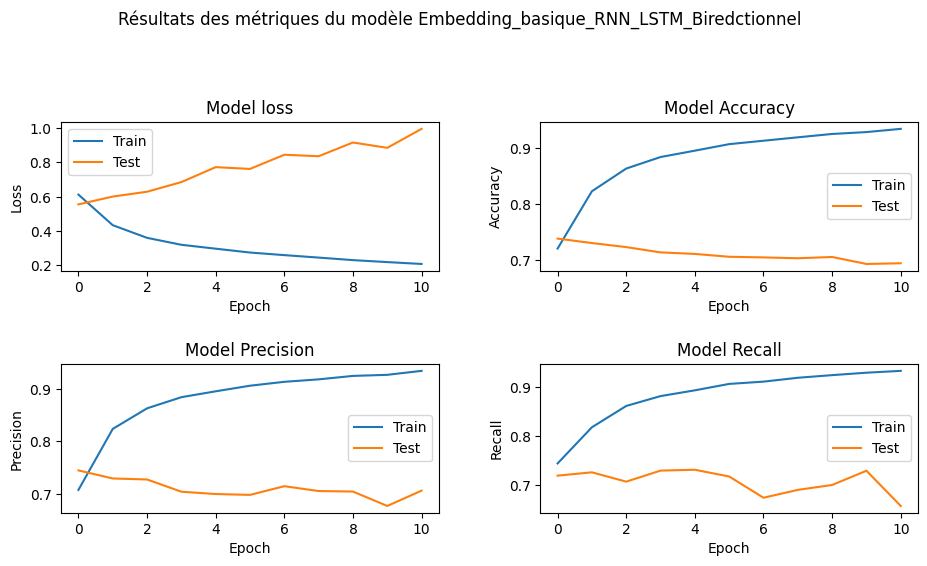

In [11]:
plot_loss_accuracy(history)

In [4]:
from azure.identity import DefaultAzureCredential
from azure.storage.blob import BlobServiceClient, BlobClient, ContainerClient

In [6]:
def get_blob_service_client_sas(self, sas_token: str):
    # TODO: Replace <storage-account-name> with your actual storage account name
    account_url = "https://p7badbuzz.blob.core.windows.net"
    # The SAS token string can be assigned to credential here or appended to the account URL
    credential = sas_token

    # Create the BlobServiceClient object
    blob_service_client = BlobServiceClient(account_url, credential=credential)

    return blob_service_client

In [12]:
model.save('./p7_global/models/Embedding_custom_RNN.keras' )

In [5]:
import keras
model = keras.models.load_model('./p7_global/models/Embedding_custom_RNN.keras')

In [6]:
text = 'I hate you please die'

In [7]:
df = import_data()
X_train, X_val, X_test, y_train, y_val, y_test = get_train_val_and_test_set(
    df, sample=True, sample_size=50_000)

new dataframe size:  37421.14 kB
optimized size by 29.0 %
new dataframe size:  26506.68  kB


CLEANING_TEXT_LEMMA DONE:   0%|          | 0/50000 [00:00<?, ?it/s]

VMEM USAGE: 46.5%|####6     |  15.2G

In [8]:
del X_val, X_test, y_train, y_val, y_test

In [9]:
tokenizer = Tokenizer()

tokenizer.fit_on_texts(X_train)
   

In [11]:
with open("./p7_global/data/tokenizer_custom.json", "w") as outfile:
    json.dump(tokenizer.to_json(), outfile)

In [57]:
len(tokenizer_loaded.word_counts)
len(tokenizer_loaded.word_docs)
len(tokenizer_loaded.word_index)

25574
25574
25574


In [58]:
import json
from keras.preprocessing.text import tokenizer_from_json
 
# Opening JSON file
with open('./p7_global/data/tokenizer_custom.json', 'r', encoding='utf-8') as openfile:
    json_object = json.load(openfile)
    tokenizer_loaded = tokenizer_from_json(json_object)
    
assert len(tokenizer.word_counts) == len(tokenizer_loaded.word_counts)
assert len(tokenizer.word_docs) == len(tokenizer_loaded.word_docs)
assert len(tokenizer.word_index) == len(tokenizer_loaded.word_index)

In [42]:
text = 'I hate you please die'
text = cleaning_text_lemma(text)
text = tokenizer.texts_to_sequences([text])
text = pad_sequences(text, dtype='float32', padding='post', maxlen=50)
text   


array([[ 77., 105., 256.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.]], dtype=float32)

In [43]:
model = keras.models.load_model('./p7_global/models/Embedding_custom_RNN.keras')

In [45]:
model(text).numpy()

array([[0.0326991]], dtype=float32)

Malgré les différentes tentatives avec des optimizers différents et des paramètrages de ceux ci différents, des pénalisation différentes des couches du modèles, celui-ci semble finir par systématiquement overfitté (loss de train de + en + faible vs loss de test de + en + élevée).

In [123]:
# mlflow.set_tracking_uri("http://127.0.0.1:8080")
# modele_simple_experiment = mlflow.set_experiment("rnn_custom")

# # Nom de l'itération en cours et chemin de stockage du modèle
# run_name = "rnn_custom_iter_2"
# artifact_path = "RNN_custom"

# metrics = {
#     "accuracy": res['accuracy'],
#     "precision": list(res.items())[2][1],
#     "recall": list(res.items())[3][1]
# }

# # Information sur le dataset utilisé
# dataset: PandasDataset = mlflow.data.from_numpy(X_train_pad, targets=y_train)

# signature = mlflow.models.infer_signature(X_test_pad, model.predict(X_test_pad))

# with mlflow.start_run(run_name=run_name) as run:

#     # Métriques
#     mlflow.log_metrics(metrics)

#     # Log d'une instance du modèle fitée
#     mlflow.tensorflow.log_model(model=model,
#                              input_example=X_test_pad,
#                              artifact_path=artifact_path,
#                                signature=signature,
#                                registered_model_name=history.model.name)

#     # Log des paramètres du dataset.
#     mlflow.log_input(dataset, context="training")

438/438 [==============================] - 3s 7ms/step
INFO:tensorflow:Assets written to: /tmp/tmpv_r_ofkn/model/data/model/assets


INFO:tensorflow:Assets written to: /tmp/tmpv_r_ofkn/model/data/model/assets
Registered model 'Embedding_basique_RNN_LSTM_Biredctionnel' already exists. Creating a new version of this model...
2023/11/04 14:42:05 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: Embedding_basique_RNN_LSTM_Biredctionnel, version 2
Created version '2' of model 'Embedding_basique_RNN_LSTM_Biredctionnel'.


## Modèle avancé Word2vec GloVe - RNN

In [15]:
# Déclaration à faire à la première utilisation uniquement.

# experiment_description = (
#     "P7 OC : Détection de bad buzz dans des tweets"
#     "Cette expérimentation se fait sur les données prepocessées normalisées passées à un RNN custom."
# )

# experiment_tags = {
#     "project_name": "P7_Detecter_bad_buz",
#     "model_classif": "rnn_word2vec_transfer",
#     "mlflow.note.content": experiment_description,
# }

# modele_simple_experiment = client.create_experiment(name="rnn_word2vec_transfer", tags=experiment_tags)


In [4]:
df = import_data()
X_train, X_val, X_test, y_train, y_val, y_test = get_train_val_and_test_set(
    df, sample=True, sample_size=50_000)

new dataframe size:  37421.14 kB
optimized size by 29.0 %
new dataframe size:  26506.68  kB


CLEANING_TEXT_LEMMA DONE:   0%|          | 0/50000 [00:00<?, ?it/s]

VMEM USAGE: 30.9%|###       |  15.2G

In [3]:
print(list(gensim.downloader.info()['models'].keys()))

['fasttext-wiki-news-subwords-300', 'conceptnet-numberbatch-17-06-300', 'word2vec-ruscorpora-300', 'word2vec-google-news-300', 'glove-wiki-gigaword-50', 'glove-wiki-gigaword-100', 'glove-wiki-gigaword-200', 'glove-wiki-gigaword-300', 'glove-twitter-25', 'glove-twitter-50', 'glove-twitter-100', 'glove-twitter-200', '__testing_word2vec-matrix-synopsis']


In [4]:
# twitter_50_wv = gensim.downloader.load('glove-twitter-50')
# twitter_100_wv = gensim.downloader.load('glove-twitter-100')
# twitter_200_wv = gensim.downloader.load('glove-twitter-200')
# wiki_gigaword_100_wv = gensim.downloader.load('glove-wiki-gigaword-100')
# google_news_100_wv = gensim.downloader.load('word2vec-google-news-300')


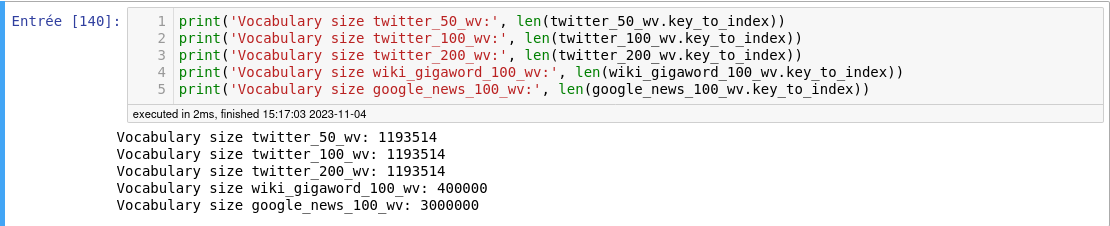

In [5]:
CHOOSED_WV = 'glove-twitter-100'

WV_SAVED_NAME = 'glove_twitter'
model_info = gensim.downloader.info()['models'][CHOOSED_WV]
VECTOR_SIZE = model_info['parameters']['dimension']
VOCAB_SIZE = model_info['num_records']

try:
    choosen_wv = KeyedVectors.load(f'./data/keyedvectors/{WV_SAVED_NAME}')
    vocab_size = len(choosen_wv.key_to_index)
    assert vocab_size == VOCAB_SIZE, \
    f"Le dictionnaire de vecteurs devrait être de taille {VOCAB_SIZE} ({vocab_size} actuellement)."
    assert choosen_wv.vector_size == VECTOR_SIZE, \
    f"L'embedding devrait être de taille {VECTOR_SIZE} ({choosen_wv.vector_size} actuellement)."
    
except:
    choosen_wv = gensim.downloader.load(CHOOSED_WV)
    choosen_wv.save(f"./data/keyedvectors/{WV_SAVED_NAME}")
    vocab_size = len(choosen_wv.key_to_index)
    assert vocab_size == VOCAB_SIZE, \
    f"Le dictionnaire de vecteurs devrait être de taille {VOCAB_SIZE} ({vocab_size} actuellement)."
    assert choosen_wv.vector_size == VECTOR_SIZE, \
    f"L'embedding devrait être de taille {VECTOR_SIZE} ({choosen_wv.vector_size} actuellement)."

print('Vocabulary size:', vocab_size)
diff_words = set([_ for elt in X_train for _ in elt])
print('Number of different words in the train set', len(diff_words))
del diff_words

Vocabulary size: 1193514
Number of different words in the train set 25574


In [6]:
# Fonction pour convertir un tweet en une matrice (aka tableau de vecteurs) contenant les représentations
# vectorielle de chaque mots dans l'espace de plongement
def embed_sentence(wv, sentence):
    embedded_sentence = []
    for word in sentence:
        # On vérifie si le mot fait bien partie du dictionnaire final
        # (peut-être exclue car trop ou pas assez fréquent).
        if word in wv:
            embedded_sentence.append(wv[word])
        
    return np.array(embedded_sentence)

# Function that converts a list of sentences into a list of matrices
def embedding(wv, sentences):
    embed = []
    
    for sentence in sentences:
        embedded_sentence = embed_sentence(wv, sentence)
        embed.append(embedded_sentence)
        
    return embed

# # Embed the training and test sentences
X_train_embed = embedding(choosen_wv, X_train)
X_val_embed = embedding(choosen_wv, X_val)
X_test_embed = embedding(choosen_wv, X_test)

SEQUENCE_LENGTH = 40
# Pad the training and test embedded sentences
X_train_pad = pad_sequences(X_train_embed, dtype='float16', padding='post', maxlen=SEQUENCE_LENGTH)
X_val_pad = pad_sequences(X_val_embed, dtype='float16', padding='post', maxlen=SEQUENCE_LENGTH)
X_test_pad = pad_sequences(X_test_embed, dtype='float16', padding='post', maxlen=SEQUENCE_LENGTH)

del X_train_embed, X_val_embed, X_test_embed

In [7]:
for X in [X_train_pad, X_val_pad, X_test_pad]:
    assert type(X) == np.ndarray, \
        f"Dataset n'est pas du type np.array ({type(X)} actuellement)."
    assert X.shape[-1] == choosen_wv.vector_size, \
        f"L'embedding devrait être de taille {choosen_wv.vector_size} ({X.shape[-1]} actuellement)."


assert X_train_pad.shape[0] == len(X_train), \
f"Taille du df train vectorisé ne correpond pas au df d'origine ({X_train_pad.shape[0]} VS {len(X_train)})"
assert X_val_pad.shape[0] == len(X_val), \
f"Taille du df validation vectorisé ne correpond pas au df d'origine ({X_train_pad.shape[0]} VS {len(X_train)})"
assert X_test_pad.shape[0] == len(X_test), \
f"Taille du df test vectorisé ne correpond pas au df d'origine ({X_test_pad.shape[0]} VS {len(X_test)})"

del X, X_train, X_val, X_test, choosen_wv


In [8]:
precision = Precision()
recall = Recall()
reg_l1 = regularizers.L1(0.001)

model = Sequential(name='Embedding_pretrained_Word2vec_RNN_LSTM')
model.add(Masking())
model.add(LSTM(60, activation='tanh', kernel_regularizer=reg_l1, return_sequences=True))
model.add(LSTM(30, activation='tanh', kernel_regularizer=reg_l1))
model.add(Dense(20, activation='relu'))
model.add(Dense(1, activation='sigmoid'))


model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy', precision, recall])

es = EarlyStopping(patience=10, restore_best_weights=True)

history = model.fit(
    X_train_pad,
    y_train,
    batch_size=128,
    epochs=1000,
    #   Possibilité d'utiliser validation_split si utilisation uniquement d'un train + test set
    #   validation_split=.3,
    validation_data=(X_val_pad, y_val),
    callbacks=[es],
    workers=15,
    use_multiprocessing=True)

res = model.evaluate(X_test_pad, y_test, verbose=0, return_dict=True)
print(f"""\n\n
Métriques du modèle:\n
- Loss:{list(res.items())[0][1]}\n
- Accuracy:{list(res.items())[1][1]}\n
- Precision:{list(res.items())[2][1]}\n
- Recall:{list(res.items())[3][1]}""")

Epoch 1/1000
250/250 [==============================] - 13s 39ms/step - loss: 1.1365 - accuracy: 0.6705 - precision: 0.6630 - recall: 0.6864 - val_loss: 0.6357 - val_accuracy: 0.7038 - val_precision: 0.7140 - val_recall: 0.6749
Epoch 2/1000
250/250 [==============================] - 8s 30ms/step - loss: 0.6086 - accuracy: 0.7178 - precision: 0.7189 - recall: 0.7104 - val_loss: 0.6094 - val_accuracy: 0.7044 - val_precision: 0.6667 - val_recall: 0.8116
Epoch 3/1000
250/250 [==============================] - 7s 30ms/step - loss: 0.5835 - accuracy: 0.7252 - precision: 0.7268 - recall: 0.7170 - val_loss: 0.5928 - val_accuracy: 0.7076 - val_precision: 0.6703 - val_recall: 0.8116
Epoch 4/1000
250/250 [==============================] - 7s 30ms/step - loss: 0.5733 - accuracy: 0.7289 - precision: 0.7282 - recall: 0.7261 - val_loss: 0.5759 - val_accuracy: 0.7231 - val_precision: 0.7105 - val_recall: 0.7485
Epoch 5/1000
250/250 [==============================] - 7s 30ms/step - loss: 0.5668 - accur

Epoch 37/1000
250/250 [==============================] - 8s 31ms/step - loss: 0.5317 - accuracy: 0.7502 - precision: 0.7486 - recall: 0.7497 - val_loss: 0.5511 - val_accuracy: 0.7369 - val_precision: 0.7664 - val_recall: 0.6776
Epoch 38/1000
250/250 [==============================] - 8s 31ms/step - loss: 0.5314 - accuracy: 0.7500 - precision: 0.7478 - recall: 0.7504 - val_loss: 0.5559 - val_accuracy: 0.7315 - val_precision: 0.7776 - val_recall: 0.6447
Epoch 39/1000
250/250 [==============================] - 8s 30ms/step - loss: 0.5326 - accuracy: 0.7510 - precision: 0.7479 - recall: 0.7534 - val_loss: 0.5480 - val_accuracy: 0.7402 - val_precision: 0.7584 - val_recall: 0.7013
Epoch 40/1000
250/250 [==============================] - 8s 30ms/step - loss: 0.5314 - accuracy: 0.7505 - precision: 0.7480 - recall: 0.7516 - val_loss: 0.5463 - val_accuracy: 0.7385 - val_precision: 0.7425 - val_recall: 0.7261
Epoch 41/1000
250/250 [==============================] - 8s 30ms/step - loss: 0.5316 - a

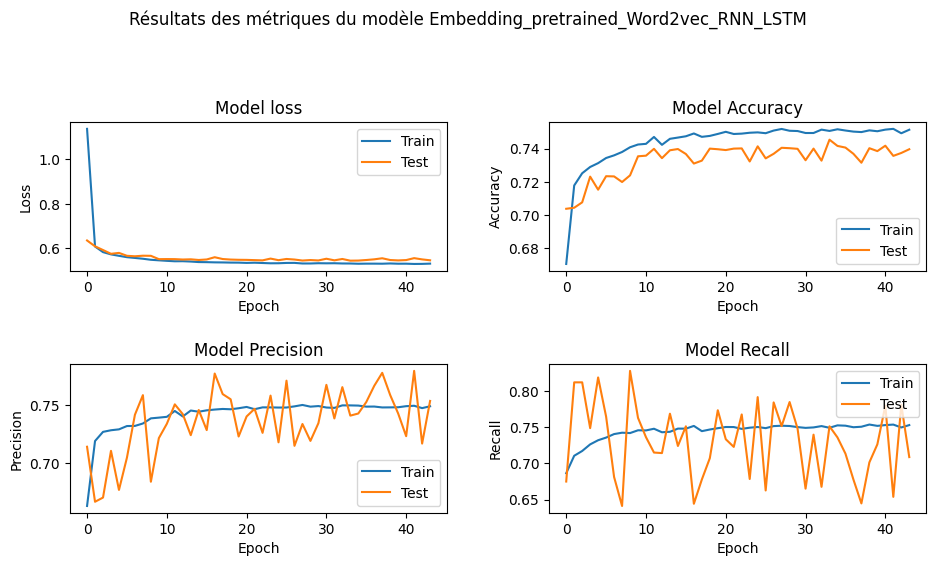

In [10]:
plot_loss_accuracy(history)

In [16]:
# mlflow.set_tracking_uri("http://127.0.0.1:8080")
# modele_simple_experiment = mlflow.set_experiment("rnn_word2vec_transfer")

# # Nom de l'itération en cours et chemin de stockage du modèle
# run_name = "rnn_word2vec_transfer_iter_2"
# artifact_path = "rnn_word2vec_transfer"

# metrics = {
#     "accuracy": res['accuracy'],
#     "precision": list(res.items())[2][1],
#     "recall": list(res.items())[3][1]
# }

# # Information sur le dataset utilisé
# dataset: PandasDataset = mlflow.data.from_numpy(X_train_pad, targets=y_train)

# signature = mlflow.models.infer_signature(X_test_pad, model.predict(X_test_pad))

# with mlflow.start_run(run_name=run_name) as run:

#     # Métriques
#     mlflow.log_metrics(metrics)

#     # Log d'une instance du modèle fitée
#     mlflow.tensorflow.log_model(model=model,
#                              input_example=X_test_pad,
#                              artifact_path=artifact_path,
#                                signature=signature,
#                                registered_model_name=history.model.name)

#     # Log des paramètres du dataset.
#     mlflow.log_input(dataset, context="training")

438/438 [==============================] - 4s 6ms/step
INFO:tensorflow:Assets written to: /tmp/tmpl4b5toub/model/data/model/assets


INFO:tensorflow:Assets written to: /tmp/tmpl4b5toub/model/data/model/assets
Registered model 'Embedding_pretrained_Word2vec_RNN_LSTM' already exists. Creating a new version of this model...
2023/11/05 18:43:27 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: Embedding_pretrained_Word2vec_RNN_LSTM, version 5
Created version '5' of model 'Embedding_pretrained_Word2vec_RNN_LSTM'.


In [23]:
precision = Precision()
recall = Recall()
reg_l1 = regularizers.L1(0.001)
reg_l2 = regularizers.L2(0.001)

model = Sequential(name='Embedding_pretrained_Word2vec_RNN_LSTM')
model.add(Masking())
model.add(GRU(60, activation='tanh', kernel_regularizer=reg_l1, return_sequences=True))
model.add(GRU(30, activation='tanh', kernel_regularizer=reg_l1))
model.add(Dense(20, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy', precision, recall])

es = EarlyStopping(patience=5, restore_best_weights=True)

history = model.fit(
    X_train_pad,
    y_train,
    batch_size=256,
    epochs=1000,
    #   Possibilité d'utiliser validation_split si utilisation uniquement d'un train + test set
    #   validation_split=.3,
    validation_data=(X_val_pad, y_val),
    callbacks=[es],
    workers=15,
    use_multiprocessing=True)

res = model.evaluate(X_test_pad, y_test, verbose=0, return_dict=True)
print(f"""\n\n
Métriques du modèle:\n
- Loss:{list(res.items())[0][1]}\n
- Accuracy:{list(res.items())[1][1]}\n
- Precision:{list(res.items())[2][1]}\n
- Recall:{list(res.items())[3][1]}""")

Epoch 1/1000
175/175 [==============================] - 13s 55ms/step - loss: 1.3027 - accuracy: 0.6887 - precision_6: 0.6874 - recall_6: 0.6903 - val_loss: 0.7109 - val_accuracy: 0.7230 - val_precision_6: 0.7191 - val_recall_6: 0.7287
Epoch 2/1000
175/175 [==============================] - 8s 46ms/step - loss: 0.6580 - accuracy: 0.7237 - precision_6: 0.7209 - recall_6: 0.7285 - val_loss: 0.6255 - val_accuracy: 0.7279 - val_precision_6: 0.7201 - val_recall_6: 0.7427
Epoch 3/1000
175/175 [==============================] - 8s 46ms/step - loss: 0.6142 - accuracy: 0.7280 - precision_6: 0.7262 - recall_6: 0.7305 - val_loss: 0.6019 - val_accuracy: 0.7312 - val_precision_6: 0.7276 - val_recall_6: 0.7358
Epoch 4/1000
175/175 [==============================] - 8s 46ms/step - loss: 0.5916 - accuracy: 0.7327 - precision_6: 0.7321 - recall_6: 0.7325 - val_loss: 0.5898 - val_accuracy: 0.7337 - val_precision_6: 0.6992 - val_recall_6: 0.8167
Epoch 5/1000
175/175 [==============================] - 8s 

Epoch 36/1000
175/175 [==============================] - 9s 50ms/step - loss: 0.5294 - accuracy: 0.7490 - precision_6: 0.7452 - recall_6: 0.7555 - val_loss: 0.5366 - val_accuracy: 0.7440 - val_precision_6: 0.7723 - val_recall_6: 0.6894
Epoch 37/1000
175/175 [==============================] - 8s 48ms/step - loss: 0.5301 - accuracy: 0.7485 - precision_6: 0.7454 - recall_6: 0.7535 - val_loss: 0.5314 - val_accuracy: 0.7472 - val_precision_6: 0.7395 - val_recall_6: 0.7606
Epoch 38/1000
175/175 [==============================] - 8s 47ms/step - loss: 0.5304 - accuracy: 0.7494 - precision_6: 0.7453 - recall_6: 0.7566 - val_loss: 0.5324 - val_accuracy: 0.7443 - val_precision_6: 0.7310 - val_recall_6: 0.7701
Epoch 39/1000
175/175 [==============================] - 8s 47ms/step - loss: 0.5317 - accuracy: 0.7483 - precision_6: 0.7451 - recall_6: 0.7536 - val_loss: 0.5344 - val_accuracy: 0.7441 - val_precision_6: 0.7683 - val_recall_6: 0.6964
Epoch 40/1000
175/175 [==============================] -

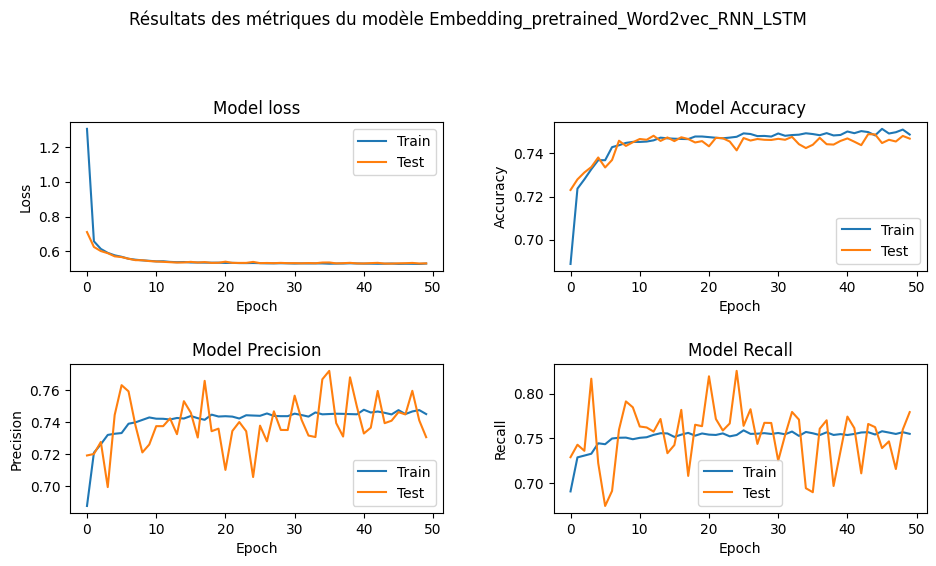

In [24]:
plot_loss_accuracy(history)

In [25]:
mlflow.set_tracking_uri("http://127.0.0.1:8080")
modele_simple_experiment = mlflow.set_experiment("rnn_word2vec_transfer")

# Nom de l'itération en cours et chemin de stockage du modèle
run_name = "rnn_word2vec_transfer_iter_2"
artifact_path = "rnn_word2vec_transfer"

metrics = {
    "accuracy": res['accuracy'],
    "precision": list(res.items())[2][1],
    "recall": list(res.items())[3][1]
}

# Information sur le dataset utilisé
dataset: PandasDataset = mlflow.data.from_numpy(X_train_pad, targets=y_train)

signature = mlflow.models.infer_signature(X_test_pad, model.predict(X_test_pad))

with mlflow.start_run(run_name=run_name) as run:

    # Métriques
    mlflow.log_metrics(metrics)

    # Log d'une instance du modèle fitée
    mlflow.tensorflow.log_model(model=model,
                             input_example=X_test_pad,
                             artifact_path=artifact_path,
                               signature=signature,
                               registered_model_name=history.model.name)

    # Log des paramètres du dataset.
    mlflow.log_input(dataset, context="training")

438/438 [==============================] - 4s 7ms/step
INFO:tensorflow:Assets written to: /tmp/tmp76f4seah/model/data/model/assets


INFO:tensorflow:Assets written to: /tmp/tmp76f4seah/model/data/model/assets
Registered model 'Embedding_pretrained_Word2vec_RNN_LSTM' already exists. Creating a new version of this model...
2023/11/05 18:58:23 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: Embedding_pretrained_Word2vec_RNN_LSTM, version 8
Created version '8' of model 'Embedding_pretrained_Word2vec_RNN_LSTM'.


## Modèle avancé Word2vec Fastext - RNN

In [8]:
# Déclaration à faire à la première utilisation uniquement.

# experiment_description = (
#     "P7 OC : Détection de bad buzz dans des tweets"
#     "Cette expérimentation se fait sur les données prepocessées normalisées passées à un RNN custom."
# )

# experiment_tags = {
#     "project_name": "P7_Detecter_bad_buz",
#     "model_classif": "rnn_word2vec_transfer",
#     "mlflow.note.content": experiment_description,
# }

# modele_simple_experiment = client.create_experiment(name="rnn_word2vec_transfer", tags=experiment_tags)


In [8]:
df = import_data()
X_train, X_val, X_test, y_train, y_val, y_test = get_train_val_and_test_set(
    df, sample=True, sample_size=70_000)

new dataframe size:  37421.14 kB
optimized size by 29.0 %
new dataframe size:  26506.68  kB


CLEANING_TEXT_LEMMA DONE:   0%|          | 0/70000 [00:00<?, ?it/s]

VMEM USAGE: 33.1%|###3      |  15.2G

In [11]:
CHOOSED_WV = 'fasttext-wiki-news-subwords-300'

WV_SAVED_NAME = 'fasttext'
model_info = gensim.downloader.info()['models'][CHOOSED_WV]
VECTOR_SIZE = model_info['parameters']['dimension']
VOCAB_SIZE = model_info['num_records']

try:
    choosen_wv = KeyedVectors.load(f'./data/keyedvectors/{WV_SAVED_NAME}')
    vocab_size = len(choosen_wv.key_to_index)
    assert vocab_size == VOCAB_SIZE,\
    f"Le dictionnaire de vecteurs devrait être de taille {VOCAB_SIZE} ({vocab_size} actuellement)."
    assert choosen_wv.vector_size == VECTOR_SIZE, \
    f"L'embedding devrait être de taille {VECTOR_SIZE} ({choosen_wv.vector_size} actuellement)."
    
except:
    choosen_wv = gensim.downloader.load(CHOOSED_WV)
    choosen_wv.save(f"./data/keyedvectors/{WV_SAVED_NAME}")
    vocab_size = len(choosen_wv.key_to_index)
    assert vocab_size == VOCAB_SIZE, \
    f"Le dictionnaire de vecteurs devrait être de taille {VOCAB_SIZE} ({vocab_size} actuellement)."
    assert choosen_wv.vector_size == VECTOR_SIZE, \
    f"L'embedding devrait être de taille {VECTOR_SIZE} ({choosen_wv.vector_size} actuellement)."

print('Vocabulary size:', vocab_size)
diff_words = set([_ for elt in X_train for _ in elt])
print('Number of different words in the train set', len(diff_words))
del diff_words

Vocabulary size: 999999
Number of different words in the train set 31343


In [12]:
# Fonction pour convertir un tweet en une matrice (aka tableau de vecteurs) contenant les représentations
# vectorielle de chaque mots dans l'espace de plongement
def embed_sentence(wv, sentence):
    embedded_sentence = []
    for word in sentence:
        # On vérifie si le mot fait bien partie du dictionnaire final
        # (peut-être exclue car trop ou pas assez fréquent).
        if word in wv:
            embedded_sentence.append(wv[word])
        
    return np.array(embedded_sentence)

# Function that converts a list of sentences into a list of matrices
def embedding(wv, sentences):
    embed = []
    
    for sentence in sentences:
        embedded_sentence = embed_sentence(wv, sentence)
        embed.append(embedded_sentence)
        
    return embed

# # Embed the training and test sentences
X_train_embed = embedding(choosen_wv, X_train)
X_val_embed = embedding(choosen_wv, X_val)
X_test_embed = embedding(choosen_wv, X_test)

SEQUENCE_LENGTH = 40
# Pad the training and test embedded sentences
X_train_pad = pad_sequences(X_train_embed, dtype='float16', padding='post', maxlen=SEQUENCE_LENGTH)
X_val_pad = pad_sequences(X_val_embed, dtype='float16', padding='post', maxlen=SEQUENCE_LENGTH)
X_test_pad = pad_sequences(X_test_embed, dtype='float16', padding='post', maxlen=SEQUENCE_LENGTH)

del X_train_embed, X_val_embed, X_test_embed

In [13]:
for X in [X_train_pad, X_val_pad, X_test_pad]:
    assert type(X) == np.ndarray, \
        f"Dataset n'est pas du type np.array ({type(X)} actuellement)."
    assert X.shape[-1] == choosen_wv.vector_size, \
        f"L'embedding devrait être de taille {choosen_wv.vector_size} ({X.shape[-1]} actuellement)."


assert X_train_pad.shape[0] == len(X_train), \
f"Taille du df train vectorisé ne correpond pas au df d'origine ({X_train_pad.shape[0]} VS {len(X_train)})"
assert X_val_pad.shape[0] == len(X_val), \
f"Taille du df validation vectorisé ne correpond pas au df d'origine ({X_train_pad.shape[0]} VS {len(X_train)})"
assert X_test_pad.shape[0] == len(X_test), \
f"Taille du df test vectorisé ne correpond pas au df d'origine ({X_test_pad.shape[0]} VS {len(X_test)})"

del X, X_train, X_val, X_test


In [8]:
precision = Precision()
recall = Recall()
reg_l1 = regularizers.L1(0.001)

model = Sequential(name='Embedding_pretrained_Word2vec_fastext_RNN_LSTM')
model.add(Masking())
model.add(LSTM(60, activation='tanh', kernel_regularizer=reg_l1, return_sequences=True))
model.add(LSTM(30, activation='tanh', kernel_regularizer=reg_l1))
model.add(Dense(20, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy', precision, recall])

es = EarlyStopping(patience=5, restore_best_weights=True)

history = model.fit(
    X_train_pad,
    y_train,
    batch_size=128,
    epochs=1000,
    #   Possibilité d'utiliser validation_split si utilisation uniquement d'un train + test set
    #   validation_split=.3,
    validation_data=(X_val_pad, y_val),
    callbacks=[es],
    workers=15,
    use_multiprocessing=True)

res = model.evaluate(X_test_pad, y_test, verbose=0, return_dict=True)
print(f"""\n\n
Métriques du modèle:\n
- Loss:{list(res.items())[0][1]}\n
- Accuracy:{list(res.items())[1][1]}\n
- Precision:{list(res.items())[2][1]}\n
- Recall:{list(res.items())[3][1]}""")

Epoch 1/1000
350/350 [==============================] - 18s 42ms/step - loss: 1.2121 - accuracy: 0.5119 - precision: 0.5115 - recall: 0.4927 - val_loss: 0.7020 - val_accuracy: 0.5227 - val_precision: 0.5245 - val_recall: 0.4491
Epoch 2/1000
350/350 [==============================] - 12s 35ms/step - loss: 0.7022 - accuracy: 0.5128 - precision: 0.5123 - recall: 0.4994 - val_loss: 0.7020 - val_accuracy: 0.5181 - val_precision: 0.5136 - val_recall: 0.6206
Epoch 3/1000
350/350 [==============================] - 12s 35ms/step - loss: 0.7022 - accuracy: 0.5137 - precision: 0.5140 - recall: 0.4736 - val_loss: 0.7017 - val_accuracy: 0.5227 - val_precision: 0.5245 - val_recall: 0.4491
Epoch 4/1000
350/350 [==============================] - 12s 35ms/step - loss: 0.7021 - accuracy: 0.5170 - precision: 0.5185 - recall: 0.4547 - val_loss: 0.7018 - val_accuracy: 0.5166 - val_precision: 0.5224 - val_recall: 0.3471
Epoch 5/1000
350/350 [==============================] - 12s 35ms/step - loss: 0.7020 - a

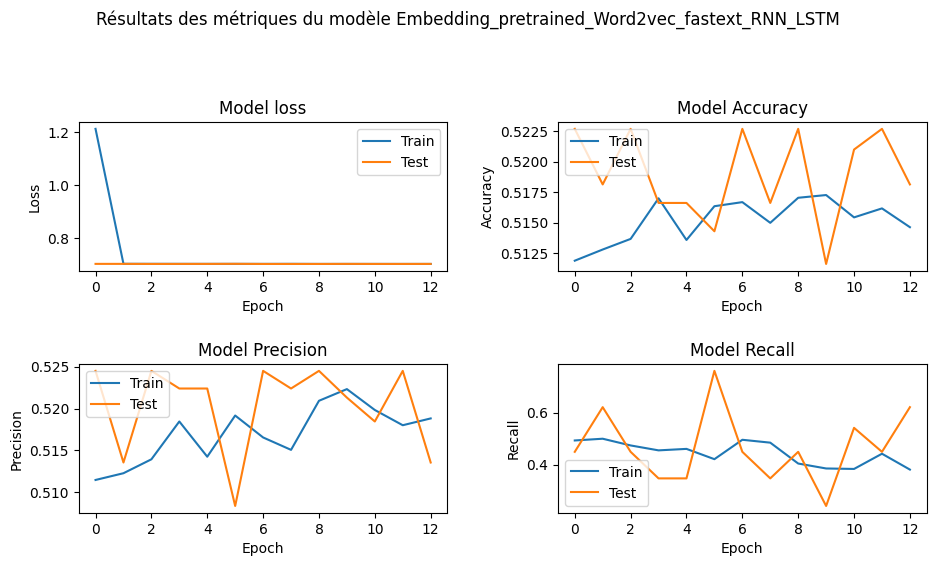

In [9]:
plot_loss_accuracy(history)

In [ ]:
precision = Precision()
recall = Recall()
reg_l1 = regularizers.L1(0.001)
reg_l2 = regularizers.L2(0.001)

model = Sequential(name='Embedding_pretrained_Word2vec_fastext_RNN_GRU')
model.add(Masking())
model.add(GRU(60, activation='tanh', kernel_regularizer=reg_l1, return_sequences=True))
model.add(GRU(30, activation='tanh', kernel_regularizer=reg_l1))
model.add(Dense(20, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy', precision, recall])

es = EarlyStopping(patience=5, restore_best_weights=True)

history = model.fit(
    X_train_pad,
    y_train,
    batch_size=256,
    epochs=1000,
    #   Possibilité d'utiliser validation_split si utilisation uniquement d'un train + test set
    #   validation_split=.3,
    validation_data=(X_val_pad, y_val),
    callbacks=[es],
    workers=15,
    use_multiprocessing=True)

res = model.evaluate(X_test_pad, y_test, verbose=0, return_dict=True)
print(f"""\n\n
Métriques du modèle:\n
- Loss:{list(res.items())[0][1]}\n
- Accuracy:{list(res.items())[1][1]}\n
- Precision:{list(res.items())[2][1]}\n
- Recall:{list(res.items())[3][1]}""")

Epoch 1/1000
175/175 [==============================] - 15s 68ms/step - loss: 1.5631 - accuracy: 0.6102 - precision_1: 0.6216 - recall_1: 0.5600 - val_loss: 0.6748 - val_accuracy: 0.6870 - val_precision_1: 0.6396 - val_recall_1: 0.8513
Epoch 2/1000
175/175 [==============================] - 10s 55ms/step - loss: 0.6332 - accuracy: 0.7069 - precision_1: 0.6973 - recall_1: 0.7297 - val_loss: 0.6061 - val_accuracy: 0.7208 - val_precision_1: 0.6801 - val_recall_1: 0.8301
Epoch 3/1000
175/175 [==============================] - 10s 56ms/step - loss: 0.5996 - accuracy: 0.7219 - precision_1: 0.7131 - recall_1: 0.7410 - val_loss: 0.5999 - val_accuracy: 0.7197 - val_precision_1: 0.7657 - val_recall_1: 0.6303
Epoch 4/1000
175/175 [==============================] - 10s 55ms/step - loss: 0.5861 - accuracy: 0.7268 - precision_1: 0.7201 - recall_1: 0.7404 - val_loss: 0.5845 - val_accuracy: 0.7276 - val_precision_1: 0.6851 - val_recall_1: 0.8389
Epoch 5/1000
175/175 [==============================] - 

In [ ]:
plot_loss_accuracy(history)

## Modèle avancé Word2vec Google News - RNN

In [ ]:
# Déclaration à faire à la première utilisation uniquement.

# experiment_description = (
#     "P7 OC : Détection de bad buzz dans des tweets"
#     "Cette expérimentation se fait sur les données prepocessées normalisées passées à un RNN custom."
# )

# experiment_tags = {
#     "project_name": "P7_Detecter_bad_buz",
#     "model_classif": "rnn_word2vec_transfer",
#     "mlflow.note.content": experiment_description,
# }

# modele_simple_experiment = client.create_experiment(name="rnn_word2vec_transfer", tags=experiment_tags)


In [7]:
df = import_data()
X_train, X_val, X_test, y_train, y_val, y_test = get_train_val_and_test_set(
    df, sample=True, sample_size=50_000)

new dataframe size:  37421.14 kB
optimized size by 29.0 %
new dataframe size:  26506.68  kB


CLEANING_TEXT_LEMMA DONE:   0%|          | 0/50000 [00:00<?, ?it/s]

VMEM USAGE: 33.9%|###3      |  15.2G

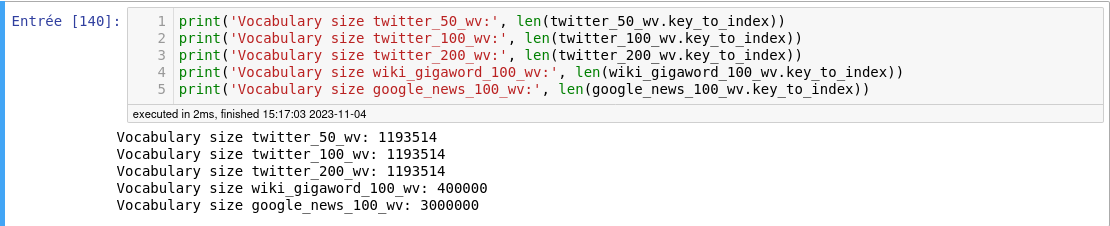

In [8]:
CHOOSED_WV = 'word2vec-google-news-300'

WV_SAVED_NAME = 'gnews'
model_info = gensim.downloader.info()['models'][CHOOSED_WV]
VECTOR_SIZE = model_info['parameters']['dimension']
VOCAB_SIZE = model_info['num_records']

try:
    choosen_wv = KeyedVectors.load(f'./data/keyedvectors/{WV_SAVED_NAME}')
    vocab_size = len(choosen_wv.key_to_index)
    assert vocab_size == VOCAB_SIZE,\
    f"Le dictionnaire de vecteurs devrait être de taille {VOCAB_SIZE} ({vocab_size} actuellement)."
    assert choosen_wv.vector_size == VECTOR_SIZE, \
    f"L'embedding devrait être de taille {VECTOR_SIZE} ({choosen_wv.vector_size} actuellement)."
    
except:
    choosen_wv = gensim.downloader.load(CHOOSED_WV)
    choosen_wv.save(f"./data/keyedvectors/{WV_SAVED_NAME}")
    vocab_size = len(choosen_wv.key_to_index)
    assert vocab_size == VOCAB_SIZE, \
    f"Le dictionnaire de vecteurs devrait être de taille {VOCAB_SIZE} ({vocab_size} actuellement)."
    assert choosen_wv.vector_size == VECTOR_SIZE, \
    f"L'embedding devrait être de taille {VECTOR_SIZE} ({choosen_wv.vector_size} actuellement)."

print('Vocabulary size:', vocab_size)
diff_words = set([_ for elt in X_train for _ in elt])
print('Number of different words in the train set', len(diff_words))
del diff_words

Vocabulary size: 3000000
Number of different words in the train set 25574


In [9]:
# Fonction pour convertir un tweet en une matrice (aka tableau de vecteurs) contenant les représentations
# vectorielle de chaque mots dans l'espace de plongement
def embed_sentence(wv, sentence):
    embedded_sentence = []
    for word in sentence:
        # On vérifie si le mot fait bien partie du dictionnaire final
        # (peut-être exclue car trop ou pas assez fréquent).
        if word in wv:
            embedded_sentence.append(wv[word])
        
    return np.array(embedded_sentence)

# Function that converts a list of sentences into a list of matrices
def embedding(wv, sentences):
    embed = []
    
    for sentence in sentences:
        embedded_sentence = embed_sentence(wv, sentence)
        embed.append(embedded_sentence)
        
    return embed

# # Embed the training and test sentences
X_train_embed = embedding(choosen_wv, X_train)
X_val_embed = embedding(choosen_wv, X_val)
X_test_embed = embedding(choosen_wv, X_test)

SEQUENCE_LENGTH = 40
# Pad the training and test embedded sentences
X_train_pad = pad_sequences(X_train_embed, dtype='float16', padding='post', maxlen=SEQUENCE_LENGTH)
X_val_pad = pad_sequences(X_val_embed, dtype='float16', padding='post', maxlen=SEQUENCE_LENGTH)
X_test_pad = pad_sequences(X_test_embed, dtype='float16', padding='post', maxlen=SEQUENCE_LENGTH)

del X_train_embed, X_val_embed, X_test_embed

In [10]:
for X in [X_train_pad, X_val_pad, X_test_pad]:
    assert type(X) == np.ndarray, \
        f"Dataset n'est pas du type np.array ({type(X)} actuellement)."
    assert X.shape[-1] == choosen_wv.vector_size, \
        f"L'embedding devrait être de taille {choosen_wv.vector_size} ({X.shape[-1]} actuellement)."


assert X_train_pad.shape[0] == len(X_train), \
f"Taille du df train vectorisé ne correpond pas au df d'origine ({X_train_pad.shape[0]} VS {len(X_train)})"
assert X_val_pad.shape[0] == len(X_val), \
f"Taille du df validation vectorisé ne correpond pas au df d'origine ({X_train_pad.shape[0]} VS {len(X_train)})"
assert X_test_pad.shape[0] == len(X_test), \
f"Taille du df test vectorisé ne correpond pas au df d'origine ({X_test_pad.shape[0]} VS {len(X_test)})"

del X, X_train, X_val, X_test


In [11]:
precision = Precision()
recall = Recall()
reg_l1 = regularizers.L1(0.001)

model = Sequential(name='Embedding_pretrained_Word2vec_gnews_RNN_LSTM')
model.add(Masking())
model.add(LSTM(60, activation='tanh', kernel_regularizer=reg_l1, return_sequences=True))
model.add(LSTM(30, activation='tanh', kernel_regularizer=reg_l1))
model.add(Dense(20, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy', precision, recall])

es = EarlyStopping(patience=5, restore_best_weights=True)

history = model.fit(
    X_train_pad,
    y_train,
    batch_size=64,
    epochs=1000,
    #   Possibilité d'utiliser validation_split si utilisation uniquement d'un train + test set
    #   validation_split=.3,
    validation_data=(X_val_pad, y_val),
    callbacks=[es],
    workers=15,
    use_multiprocessing=True)

res = model.evaluate(X_test_pad, y_test, verbose=0, return_dict=True)
print(f"""\n\n
Métriques du modèle:\n
- Loss:{list(res.items())[0][1]}\n
- Accuracy:{list(res.items())[1][1]}\n
- Precision:{list(res.items())[2][1]}\n
- Recall:{list(res.items())[3][1]}""")

Epoch 1/1000
500/500 [==============================] - 16s 26ms/step - loss: 1.0626 - accuracy: 0.5181 - precision: 0.5180 - recall: 0.4472 - val_loss: 0.7018 - val_accuracy: 0.5178 - val_precision: 0.5325 - val_recall: 0.2513
Epoch 2/1000
500/500 [==============================] - 12s 23ms/step - loss: 0.7019 - accuracy: 0.5142 - precision: 0.5138 - recall: 0.4343 - val_loss: 0.7014 - val_accuracy: 0.5241 - val_precision: 0.5320 - val_recall: 0.3618
Epoch 3/1000
500/500 [==============================] - 12s 23ms/step - loss: 0.7018 - accuracy: 0.5171 - precision: 0.5178 - recall: 0.4253 - val_loss: 0.7012 - val_accuracy: 0.5228 - val_precision: 0.5187 - val_recall: 0.5633
Epoch 4/1000
500/500 [==============================] - 12s 23ms/step - loss: 0.7019 - accuracy: 0.5185 - precision: 0.5207 - recall: 0.4007 - val_loss: 0.7017 - val_accuracy: 0.5207 - val_precision: 0.5146 - val_recall: 0.6457
Epoch 5/1000
500/500 [==============================] - 12s 23ms/step - loss: 0.7017 - a

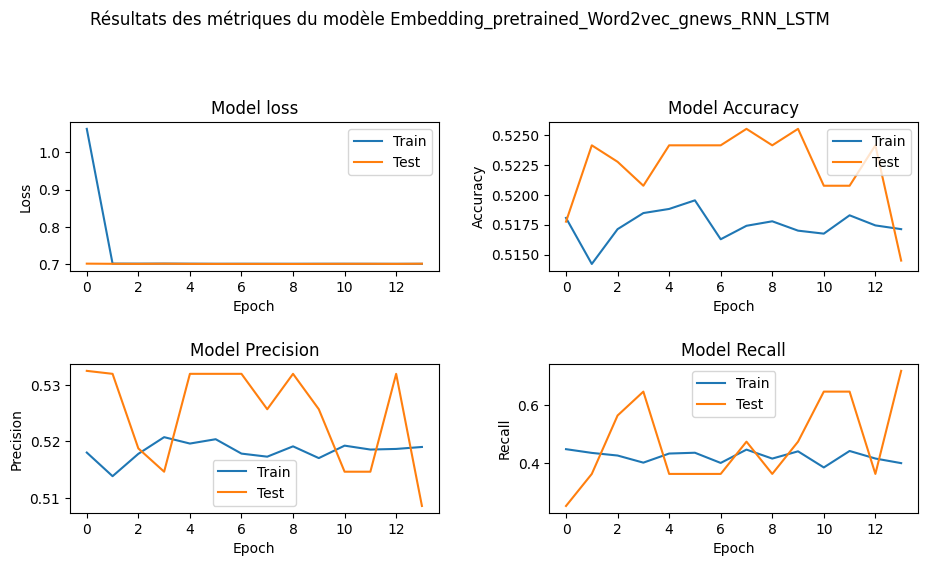

In [12]:
plot_loss_accuracy(history)

In [ ]:
precision = Precision()
recall = Recall()
reg_l1 = regularizers.L1(0.001)
reg_l2 = regularizers.L2(0.001)

model = Sequential(name='Embedding_pretrained_Word2vec_gnews_RNN_GRU')
model.add(Masking())
model.add(GRU(60, activation='tanh', kernel_regularizer=reg_l1, return_sequences=True))
model.add(GRU(30, activation='tanh', kernel_regularizer=reg_l1))
model.add(Dense(20, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy', precision, recall])

es = EarlyStopping(patience=5, restore_best_weights=True)

history = model.fit(
    X_train_pad,
    y_train,
    batch_size=256,
    epochs=1000,
    #   Possibilité d'utiliser validation_split si utilisation uniquement d'un train + test set
    #   validation_split=.3,
    validation_data=(X_val_pad, y_val),
    callbacks=[es],
    workers=15,
    use_multiprocessing=True)

res = model.evaluate(X_test_pad, y_test, verbose=0, return_dict=True)
print(f"""\n\n
Métriques du modèle:\n
- Loss:{list(res.items())[0][1]}\n
- Accuracy:{list(res.items())[1][1]}\n
- Precision:{list(res.items())[2][1]}\n
- Recall:{list(res.items())[3][1]}""")

In [ ]:
plot_loss_accuracy(history)

## Modèle avancé BERT

In [ ]:
# Déclaration à faire à la première utilisation uniquement.

# experiment_description = (
#     "P7 OC : Détection de bad buzz dans des tweets"
#     "Cette expérimentation se fait sur les données prepocessées normalisées passées à un RNN custom."
# )

# experiment_tags = {
#     "project_name": "P7_Detecter_bad_buz",
#     "model_classif": "rnn_word2vec_transfer",
#     "mlflow.note.content": experiment_description,
# }

# modele_simple_experiment = client.create_experiment(name="rnn_word2vec_transfer", tags=experiment_tags)


In [41]:
df = import_data().sample(50_000, random_state=1032)
df.shape

new dataframe size:  37421.14 kB
optimized size by 29.0 %
new dataframe size:  26506.68  kB


(50000, 3)

In [42]:
from transformers import TFAutoModel
from transformers import AutoTokenizer, AutoConfig

from tensorflow import expand_dims

import numpy as np
from scipy.special import softmax

# Preprocess text (username and link placeholders)
def preprocess(text):
    new_text = []
    for t in text.split(" "):
        t = '@user' if t.startswith('@') and len(t) > 1 else t
        t = 'http' if t.startswith('http') else t
        new_text.append(t)
    return " ".join(new_text)


In [48]:
try:

    # On charge le tokenizer pour convertir les phrases
    MODEL = "cardiffnlp/twitter-roberta-base-sentiment-latest"
    # On précise le padding = right (== padding = post) comme attendu par les modèles BERT
    tokenizer = AutoTokenizer.from_pretrained(MODEL, padding_side='right')
    config = AutoConfig.from_pretrained(MODEL)
except:
    ! rm -rf cardiffnlp
        # On précise le padding = right (== padding = post) comme attendu par les modèles BERT
    tokenizer = AutoTokenizer.from_pretrained(MODEL, padding_side='right')
    config = AutoConfig.from_pretrained(MODEL)
    TOKENIZERS_PARALLELISM=true


In [49]:
# On cahrge le modèle BERT en utilisant le paramètre from_pt=True pour récupérer un comportement équivalent
# à un modèle TF
model = TFAutoModel.from_pretrained(MODEL, from_pt=True)
model.save_pretrained(MODEL)

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFRobertaModel: ['classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.dense.bias', 'classifier.out_proj.weight', 'roberta.embeddings.position_ids']
- This IS expected if you are initializing TFRobertaModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFRobertaModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaModel for predictions without further training.


In [50]:
model.summary()

Model: "tf_roberta_model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 roberta (TFRobertaMainLaye  multiple                  124645632 
 r)                                                              
                                                                 
Total params: 124645632 (475.49 MB)
Trainable params: 124645632 (475.49 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [51]:
print('Nombre de paramètres du modèle préentrainé :',model.num_parameters())

Nombre de paramètres du modèle préentrainé : 124645632


In [52]:
df.loc[1252080].text

"Well what a day!  Not been too bad but am exhausted now. Happy to finally be with that special someone, i'm so very lucky.."

In [53]:
tokens = tokenizer(preprocess(df.loc[1252080].text))["input_ids"]
print("Avec preprocessing proposé par Hugging Face: \n")
print(f"Nombre de tokens : {len(tokens)} (nombre de mots dans la phrase: {len(df.loc[1252080].text.split())})\n")
for x in tokens:
    print(f"{x} corresponds to {tokenizer.decode(x)}")

Avec preprocessing proposé par Hugging Face: 

Nombre de tokens : 32 (nombre de mots dans la phrase: 24)

0 corresponds to <s>
8346 corresponds to Well
99 corresponds to  what
10 corresponds to  a
183 corresponds to  day
328 corresponds to !
1437 corresponds to  
1491 corresponds to  Not
57 corresponds to  been
350 corresponds to  too
1099 corresponds to  bad
53 corresponds to  but
524 corresponds to  am
17067 corresponds to  exhausted
122 corresponds to  now
4 corresponds to .
9899 corresponds to  Happy
7 corresponds to  to
1747 corresponds to  finally
28 corresponds to  be
19 corresponds to  with
14 corresponds to  that
780 corresponds to  special
951 corresponds to  someone
6 corresponds to ,
939 corresponds to  i
437 corresponds to 'm
98 corresponds to  so
182 corresponds to  very
5394 corresponds to  lucky
7586 corresponds to ..
2 corresponds to </s>


In [54]:
df = import_data().sample(10_000, random_state=1032)
tokenized_tensors = tokenizer(df["text"].apply(preprocess).tolist(), max_length=50, padding = "max_length", truncation = True, return_tensors="tf")


new dataframe size:  37421.14 kB
optimized size by 29.0 %
new dataframe size:  26506.68  kB


In [55]:
tokenized_tensors["input_ids"].shape

TensorShape([10000, 50])

In [90]:
embeddings = model.predict(tokenized_tensors["input_ids"], workers=15, use_multiprocessing=True)

OperatorNotAllowedInGraphError: in user code:

    File "/home/pjcggf/.pyenv/versions/3.10.6/envs/OC/lib/python3.10/site-packages/keras/src/engine/training.py", line 2416, in predict_function  *
        return step_function(self, iterator)
    File "/home/pjcggf/.pyenv/versions/3.10.6/envs/OC/lib/python3.10/site-packages/keras/src/engine/training.py", line 2401, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/home/pjcggf/.pyenv/versions/3.10.6/envs/OC/lib/python3.10/site-packages/keras/src/engine/training.py", line 2389, in run_step  **
        outputs = model.predict_step(data)
    File "/home/pjcggf/.pyenv/versions/3.10.6/envs/OC/lib/python3.10/site-packages/keras/src/engine/training.py", line 2357, in predict_step
        return self(x, training=False)
    File "/home/pjcggf/.pyenv/versions/3.10.6/envs/OC/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None

    OperatorNotAllowedInGraphError: Exception encountered when calling layer 'tf_roberta_model_2' (type TFRobertaModel).
    
    in user code:
    
        File "/home/pjcggf/.pyenv/versions/3.10.6/envs/OC/lib/python3.10/site-packages/transformers/modeling_tf_utils.py", line 1265, in run_call_with_unpacked_inputs  *
            return func(self, **unpacked_inputs)
        File "/home/pjcggf/.pyenv/versions/3.10.6/envs/OC/lib/python3.10/site-packages/transformers/models/roberta/modeling_tf_roberta.py", line 930, in call  *
            outputs = self.roberta(
        File "/home/pjcggf/.pyenv/versions/3.10.6/envs/OC/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler  **
            raise e.with_traceback(filtered_tb) from None
    
        OperatorNotAllowedInGraphError: Exception encountered when calling layer 'roberta' (type TFRobertaMainLayer).
        
        in user code:
        
            File "/home/pjcggf/.pyenv/versions/3.10.6/envs/OC/lib/python3.10/site-packages/transformers/modeling_tf_utils.py", line 1265, in run_call_with_unpacked_inputs  *
                return func(self, **unpacked_inputs)
            File "/home/pjcggf/.pyenv/versions/3.10.6/envs/OC/lib/python3.10/site-packages/transformers/models/roberta/modeling_tf_roberta.py", line 640, in call  *
                batch_size, seq_length = input_shape
        
            OperatorNotAllowedInGraphError: Iterating over a symbolic `tf.Tensor` is not allowed. You can attempt the following resolutions to the problem: If you are running in Graph mode, use Eager execution mode or decorate this function with @tf.function. If you are using AutoGraph, you can try decorating this function with @tf.function. If that does not work, then you may be using an unsupported feature or your source code may not be visible to AutoGraph. See https://github.com/tensorflow/tensorflow/blob/master/tensorflow/python/autograph/g3doc/reference/limitations.md#access-to-source-code for more information.
        
        
        Call arguments received by layer 'roberta' (type TFRobertaMainLayer):
          • input_ids=tf.Tensor(shape=<unknown>, dtype=int32)
          • attention_mask=None
          • token_type_ids=None
          • position_ids=None
          • head_mask=None
          • inputs_embeds=None
          • encoder_hidden_states=None
          • encoder_attention_mask=None
          • past_key_values=None
          • use_cache=True
          • output_attentions=False
          • output_hidden_states=False
          • return_dict=True
          • training=False
    
    
    Call arguments received by layer 'tf_roberta_model_2' (type TFRobertaModel):
      • input_ids=tf.Tensor(shape=<unknown>, dtype=int32)
      • attention_mask=None
      • token_type_ids=None
      • position_ids=None
      • head_mask=None
      • inputs_embeds=None
      • encoder_hidden_states=None
      • encoder_attention_mask=None
      • past_key_values=None
      • use_cache=None
      • output_attentions=None
      • output_hidden_states=None
      • return_dict=None
      • training=False


Le X dont on va se servir pour la prédiction est uniquement le premier token de la phrase (`<s>`) qui contient l'embedding du tweet lui-même, et est donc suffisant pour la traiter en entier.


In [95]:
# On trouve bien ici nos 10000 tweets, décomposé en 50 vecteurs de taille 768
embeddings.last_hidden_state.shape

(10000, 50, 768)

In [84]:
# On récupère uniquement le premier vecteur de chaque tweet.
X = embeddings.last_hidden_state[:,0,:]
X[0].shape

(768,)

In [103]:
X_train, X_test, y_train, y_test = train_test_split(X, df["target"].apply(lambda x: 1 if x == 4 else 0).to_numpy())

assert X_train.shape[0] == y_train.shape[0], \
f"Les shapes X_train et y_train ne correspondent pas ({X_train.shape[0]} vs {y_train.shape[0]})"
assert X_test.shape[0] == y_test.shape[0], \
f"Les shapes X_test et y_test ne correspondent pas ({X_test.shape[0]} vs {y_test.shape[0]})"
assert isinstance(X_train, np.ndarray), \
f"X_train n'est pas du type np.array mais {type(X_train)}"
assert isinstance(y_train, np.ndarray), \
f"y_train n'est pas du type np.array mais {type(y_train)}"

In [187]:
# Define a learning rate schedule
learning_rate_schedule = schedules.ExponentialDecay(
    initial_learning_rate=0.01,
    decay_steps=10000,
    decay_rate=0.96
)

# Create an optimizer with the learning rate schedule
optimizer = Adam(learning_rate=learning_rate_schedule)
# optimizer = Adam(learning_rate=0.1)


# # Define a callback to modify the learning rate dynamically
# lr_callback = ReduceLROnPlateau(
#     monitor='val_loss',
#     factor=0.1,
#     patience=10,
#     min_lr=0.00001
# )


In [188]:
precision = Precision()
recall = Recall()
reg_l1 = regularizers.L1(0.001)
reg_l2 = regularizers.L2(0.001)

input_shape = (768,) 

dense_model = Sequential([
    Dense(512, activation='relu', input_shape=input_shape, kernel_regularizer=reg_l2),
    Dropout(0.3),
    Dense(256, activation='relu',kernel_regularizer=reg_l2),
    Dropout(0.2),
    Flatten(),
    Dense(1, activation='sigmoid')
])

In [189]:
dense_model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy', precision, recall])

es = EarlyStopping(patience=10, restore_best_weights=True)

history = dense_model.fit(X_train, y_train, validation_split=0.2, epochs=200, callbacks=[es])

res = dense_model.evaluate(X_test, y_test, return_dict=True)
print(f"""\n\n
Métriques du modèle:\n
- Loss:{list(res.items())[0][1]}\n
- Accuracy:{list(res.items())[1][1]}\n
- Precision:{list(res.items())[2][1]}\n
- Recall:{list(res.items())[3][1]}""")

Epoch 1/200
188/188 [==============================] - 1s 4ms/step - loss: 0.9839 - accuracy: 0.7843 - precision_17: 0.7920 - recall_17: 0.7884 - val_loss: 0.5873 - val_accuracy: 0.7873 - val_precision_17: 0.7679 - val_recall_17: 0.8146
Epoch 2/200
188/188 [==============================] - 1s 3ms/step - loss: 0.5465 - accuracy: 0.8022 - precision_17: 0.8163 - recall_17: 0.7949 - val_loss: 0.5248 - val_accuracy: 0.7853 - val_precision_17: 0.7503 - val_recall_17: 0.8457
Epoch 3/200
188/188 [==============================] - 1s 3ms/step - loss: 0.5119 - accuracy: 0.7983 - precision_17: 0.8126 - recall_17: 0.7910 - val_loss: 0.5118 - val_accuracy: 0.7913 - val_precision_17: 0.7832 - val_recall_17: 0.7970
Epoch 4/200
188/188 [==============================] - 1s 3ms/step - loss: 0.4958 - accuracy: 0.7952 - precision_17: 0.8067 - recall_17: 0.7923 - val_loss: 0.4831 - val_accuracy: 0.7927 - val_precision_17: 0.7695 - val_recall_17: 0.8268
Epoch 5/200
188/188 [==============================]

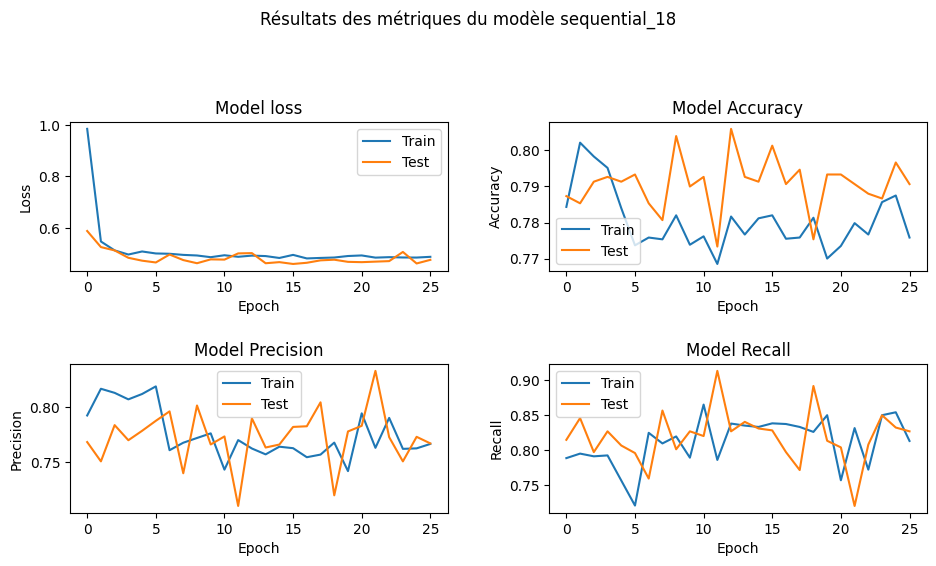

In [190]:
plot_loss_accuracy(history)